# **Crypto Shorting**

### Antoni Tomaszewski

### Andrzej Herman

## **Project introduction**
### Idea of the project is simple. Let's take a simple strategy of investing in the bitcoin market, then analyze it and try to improve as much as possible. The data we will be using are minute records of bitcoin prices over the years 2012-2020.


---



### Useful code that represents the stock, executing transactions and calculates the relevant indicators:

In [1]:
import time
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly
import seaborn as sns
%matplotlib inline

In [2]:
def timeit(f):
    """
    simple decorator for measuring time of function execution
    """
    def _timeit(*args, **kwargs):
        start = time.time()
        result = f(*args, **kwargs)
        end = time.time()
        print(f'Time of execution : {round(end-start, 2)} seconds')
        return result
    return _timeit
    
def index_to_date(index):
    from datetime import datetime
    base = 1609372800 - 1000000*60
    timestamp = base + 60 * index
    return datetime.fromtimestamp(timestamp)
# print(index_to_date(1000000))

In [ ]:
# from google.colab import files
# uploaded = files.upload() #upload BTC.csv


Saving bitstampUSD_1-min_data_2012-01-01_to_2020-12-31.csv to bitstampUSD_1-min_data_2012-01-01_to_2020-12-31.csv


In [4]:
class Stock:
    """
    Holds all information about stock prices, and history of all our trades
    """

    def __init__(self, file='BTC.csv', k=2, n=20,
                 time_frame=1000000,  time_step=1, money=100,
                 commission=1):
        self.stock_df = Stock.process_file(file, k, n, time_frame, time_step)
        self.transactions = []
        self.k = k
        self.n = n
        self.time_frame = time_frame
        self.time_step = time_step
        self.money = money
        self.commission = commission
        self.index = self.stock_df.index.start

    def process_file(file, k, n, time_frame, time_step):
        stock_df = pd.read_csv(file)[['Open']].rename(columns={'Open': 'open'}).dropna().loc[::time_step]
        # stock_df = stock_df[-time_frame - n:]
        stock_df['ma1'] = Stock.MA(stock_df['open'], span=1)
        stock_df['avg'] = Stock.MA(stock_df['open'], span=n)
        stock_df['avg16'] = Stock.MA(stock_df['open'], span=16)
        stock_df['avg64'] = Stock.MA(stock_df['open'], span=64)
        stock_df['avg256'] = Stock.MA(stock_df['open'], span=256)
        stock_df['avg1024'] = Stock.MA(stock_df['open'], span=1024)
        stock_df['avg4096'] = Stock.MA(stock_df['open'], span=4096)

        stock_df[f'std{k}'] = Stock.std(stock_df['open'], span=n)

        stock_df['upper'] = stock_df['avg'] + k * stock_df[f'std{k}']
        stock_df['lower'] = stock_df['avg'] - k * stock_df[f'std{k}']

        stock_df['upper64'] = stock_df['avg64'] + k * stock_df['avg64']
        stock_df['lower64'] = stock_df['avg64'] - k * stock_df['avg64']

        stock_df['upper256'] = stock_df['avg256'] + k * stock_df['avg256']
        stock_df['lower256'] = stock_df['avg256'] - k * stock_df['avg256']

        stock_df['upper1024'] = stock_df['avg1024'] + k * stock_df['avg1024']
        stock_df['lower1024'] = stock_df['avg1024'] - k * stock_df['avg1024']

        stock_df['upper4096'] = stock_df['avg4096'] + k * stock_df['avg4096']
        stock_df['lower4096'] = stock_df['avg4096'] - k * stock_df['avg4096']

        stock_df = stock_df[-time_frame:]
        return stock_df.reset_index(drop=True)

    def MA(series, span):
        return series.rolling(span).mean()

    def std(series, span):
        return series.rolling(span).std()

    def get_row(self, index):
        return self.stock_df.loc[[index]]

    def __iter__(self):
        return self


    def __next__(self):
        if self.index < self.stock_df.index.stop:
            if self.index > 0:
                prev_signal = Signal(self.get_row(self.index-1))
            else:
                prev_signal = None
            result = Signal(self.get_row(self.index), previous_signal=prev_signal)
            self.index += self.stock_df.index.step
            return result
        else:
            raise StopIteration

    def __repr__(self):
        return f'''money: {round(self.money, 3)}\ntransactions: {len(self.transactions)}'''

    def make_transaction(self, signal_begin, signal_end):
        history = self.get_history(signal_begin)
        transaction = Transaction(history, signal_begin, signal_end,
                                  self.money, self.commission)
        self.transactions.append(transaction)
        self.money = transaction.money_output

    def get_history(self, signal_begin):
        return self.stock_df.loc[signal_begin.index - 49:
                                 signal_begin.index]

      
    def get_data_for_ML(self):
        return pd.DataFrame(columns=['Result'] + list(range(7*50 + 1)),
                            data=([transaction.profitability]
                                  + list(transaction.history.open /
                                         transaction.history.open.iloc[-1])
                                  + list(transaction.history.lower /
                                         transaction.history.open.iloc[-1])
                                  + list(transaction.history.avg16 /
                                         transaction.history.open.iloc[-1])
                                  + list(transaction.history.avg64 /
                                         transaction.history.open.iloc[-1])
                                  + list(transaction.history.avg256 /
                                         transaction.history.open.iloc[-1])
                                  + list(transaction.history.lower256 /
                                         transaction.history.open.iloc[-1])
                                  + list(transaction.history.avg1024 /
                                         transaction.history.open.iloc[-1])                              
                                  + [transaction.commission * transaction.price_end / transaction.price_begin]
                                  for transaction in self.transactions)
                            )
    @property
    def signal_iterator(self):
        for i in range(self.index + self.stock_df.index.step, self.stock_df.index.stop, self.stock_df.index.step):
            if i > 0:
                prev_signal = Signal(self.get_row(i-1))
            else:
                prev_signal = None
            yield Signal(self.get_row(i), previous_signal=prev_signal)
            
class Transaction:
    """
    Represents transaction buy->sell,
    history will be used for machine learning algorithms to teach them how data
     'looks' before profitable purchase of stock
    """

    def __init__(self, history, signal_begin, signal_end,
                 money_input, commission):
        self.history = history
        self.signal_begin = signal_begin
        self.signal_end = signal_end
        self.price_begin = signal_begin.get_price()
        self.price_end = signal_end.get_price()
        self.money_input = money_input
        self.commission = commission
        self.money_output = commission * money_input * \
            self.price_end / self.price_begin
        self.rate = commission * self.price_end / self.price_begin
        self.profitability = self.money_input < self.money_output

    # def __repr__(self):
    #     return f'{self.profitability}'

    
class Signal:
    """
    Represents single row of Stock data
    """
    index = property()

    def __init__(self, row, previous_signal = None):
        self.row = row
        self.previous_signal = previous_signal

    @index.getter
    def index(self):
        return self.row.index[0]

    def get_price(self, column='open'):
        return float(self.row[column])

    def is_buy_start(self):
        if not self.previous_signal:
            return self.get_price('open') < self.get_price('lower')
        if not self.previous_signal.is_buy_start():
            return self.get_price('open') < self.get_price('lower')
        return False

    def is_buy_stop(self):
        if not self.previous_signal:
            return self.get_price('open') > self.get_price('avg')
        if not self.previous_signal.is_buy_stop():
            return self.get_price('open') > self.get_price('avg')
        return False

    def __repr__(self):
        return f'{self.row}'
    
@timeit
# @lru_cache(maxsize=None)
def bollinger(*args, **kwargs):
    stock = Stock(*args, **kwargs)
    for signal_begin in stock:
        if signal_begin.is_buy_start():
            # for signal_end in stock #if you want to select signal begins greedy:
            for signal_end in stock.signal_iterator:
                if signal_end.is_buy_stop():
                    stock.make_transaction(signal_begin, signal_end)
                    break
    return stock

with open('middle_strategy//stock_n_200.txt', 'rb') as fh:
    stock = pickle.load(fh)
median = float(pd.DataFrame([transaction.rate for transaction in stock.transactions]).median())

def get_data_for_ML(stock=stock):
    return pd.DataFrame(data=([transaction.rate > median]
                              + list(transaction.history.open /
                                     transaction.history.open.iloc[-1])
                              + list(transaction.history.lower /
                                     transaction.history.open.iloc[-1])
                              + list(transaction.history.avg16 /
                                     transaction.history.open.iloc[-1])
                              + list(transaction.history.avg64 /
                                     transaction.history.open.iloc[-1])
                              + list(transaction.history.avg256 /
                                     transaction.history.open.iloc[-1])
                              + list(transaction.history.lower256 /
                                     transaction.history.open.iloc[-1])
                              + list(transaction.history.avg1024 /
                                     transaction.history.open.iloc[-1])                              
                              + [stock.commission * transaction.price_end / transaction.price_begin,
                                 transaction.signal_begin.index,
                                 transaction.signal_end.index]
                              for transaction in stock.transactions)
                        )

In [322]:
def money_counter(y_pred, rate_in_out, commission=1):
#     print(len(y_pred), len(rate_in_out))
    from functools import reduce
    df = rate_in_out[y_pred]
    selected = rate_in_out[y_pred].diff()['index_out'] > 0
    if not selected.any():
        return 1
    selected.iloc[0] = True
    df = df[selected]
    return reduce(lambda x,y:x*y*commission, df['rate']) 

def money_counter(y_pred, rate_in_out, commission=1):
    df = rate_in_out[y_pred]
    rate = 1.
    prev_out = -1
    for i in df.index:
        if df.loc[i, 'index_in'] > prev_out:
            rate *= df.loc[i, 'rate']*commission
            prev_out = df.loc[i, 'index_out']
    return rate

def money_leverage_counter(y_pred, rate_in_out, commission=1, leverage=1, history=False):
    stop_rate = 1-1/leverage
#     stop_rate = .8
    df = rate_in_out[y_pred]
    rate = 1.
    prev_out = -1
    hist = pd.DataFrame(columns = ['rate', 'index_in', 'index_out'])
    hist = hist.append({'rate':rate, 'index_in':df.loc[df.index[0], 'index_in'], 'index_out':df.loc[df.index[0], 'index_in']}, ignore_index=True)
    for i in df.index:
        row = df.loc[i]
        in_value = stock.stock_df['open'].loc[row['index_in']]
        stop_value = in_value*stop_rate
        between_in_out = stock.stock_df['open'].loc[row['index_in']:row['index_out']]
        bigger_losses = between_in_out[between_in_out < stop_value]
        if bigger_losses.any():
#             return in_value, stop_value, between_in_out, bigger_losses, row
            return 0, hist
        if df.loc[i, 'index_in'] > prev_out:
            new_rate = df.loc[i, 'rate']
            rate = rate * (leverage*new_rate*commission - leverage + 1)
            prev_out = df.loc[i, 'index_out']
            if history:
                hist = hist.append({'rate':rate, 'index_in':df.loc[i, 'index_in'], 'index_out':prev_out}, ignore_index=True)
    if history:
        return rate, hist
    return rate

In [323]:
def get_max_loss(y_pred, rate_in_out):
    from functools import reduce
    df = rate_in_out[y_pred]
    min_rate = 2
    for i in df.index:
        row = df.loc[i]
        in_value = stock.stock_df['open'].loc[row['index_in']]
        min_value = min(stock.stock_df['open'].loc[row['index_in']:row['index_out']+1])
        min_rate = min(min_rate,
                     min_value/in_value)
    return min_rate

def stop_loss(y_pred, rate_in_out, stop_rate):
    df = rate_in_out.copy()
    for i, y_pred_value in zip(df.index, y_pred):
        if not y_pred_value:
            continue
        row = df.loc[i]
        in_value = stock.stock_df['open'].loc[row['index_in']]
        stop_value = in_value*stop_rate
        between_in_out = stock.stock_df['open'].loc[row['index_in']:row['index_out']]
        bigger_losses = between_in_out[between_in_out < stop_value]
        
        if bigger_losses.any():
#             return in_value, stop_value, between_in_out, bigger_losses
            df.loc[i, 'index_out'] = bigger_losses.index[0]
            df.loc[i, 'rate'] = bigger_losses.iloc[0] / in_value
    return df
h = money_leverage_counter(y_val_pred, rate_in_out_val, .93)
h0 = stop_loss(y_val_pred, rate_in_out_val, .93)

In [7]:
class Window:
    def __init__(self, transaction):
        self.data = transaction.history[[
            'open', 'avg16', 'avg64', 'avg256', 'lower']].reset_index(drop=True)
        self.data.rename(columns={'open': 'price'}, inplace=True)

    def normalize(self):
        self.data /= self.data.iloc[-1].price
        return self

    def draw(self):
        fig = go.Figure()
        for row in self.data:
            fig.add_trace(go.Scatter(
                x=self.data.index,
                y=self.data[row],
                mode='lines',
                name=row
            ))
        fig.update_layout(title='Saved history of the stock exchange situation before starting transaction', font=dict(size=18))
        fig.show()

## **Strategy**
### Let's create a chart with relevant indicators on the basis of which it will be easy to discuss the concept.

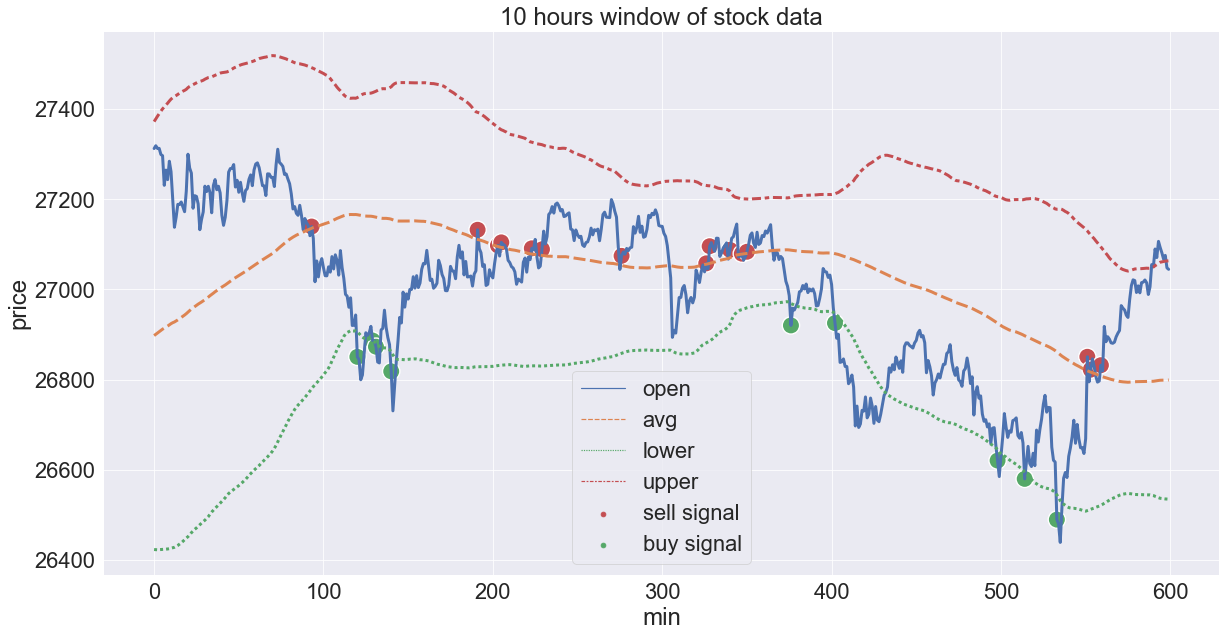

In [14]:
data=stock.stock_df.iloc[-3500:-2900][['open', 'avg', 'lower', 'upper']].reset_index(drop=True)
moments = pd.DataFrame()
for ind in data.index:
    if ind > 0:
        prev = Signal(data.iloc[ind-1])
    else:
        prev = None
    row = data.iloc[ind]
    sig = Signal(row, prev)
    if sig.is_buy_start():
        row['action'] = 'buy signal'
        moments = moments.append(row)
    if sig.is_buy_stop():
        row['action'] = 'sell signal'
        moments = moments.append(row)
moments.drop([0], inplace=True)
moments.reset_index(inplace=True)
sns.set(rc={'figure.figsize':(20,10)})
sns.set_context("paper", font_scale=2.5)
sns.scatterplot(data=moments, x='index', y='open', hue='action', palette=['r', 'g'],s=300)
plot = sns.lineplot(data=data, linewidth = 3).set(title='10 hours window of stock data', ylabel='price', xlabel='min', )


### The strategy we will use is to calculate the Bollinger Bands and moving average and observe how the price of bitcoin performs against them. Everytime the price drops below the lower band, we expect it to increase until it reaches the average. All drops below the band will be recorded as signals to buy bitcoin, while a return to the average is a signal in which we will sell all shares.

---



We made 11926 transactions
76.88% above rate 1.
58.42% above rate 1.002


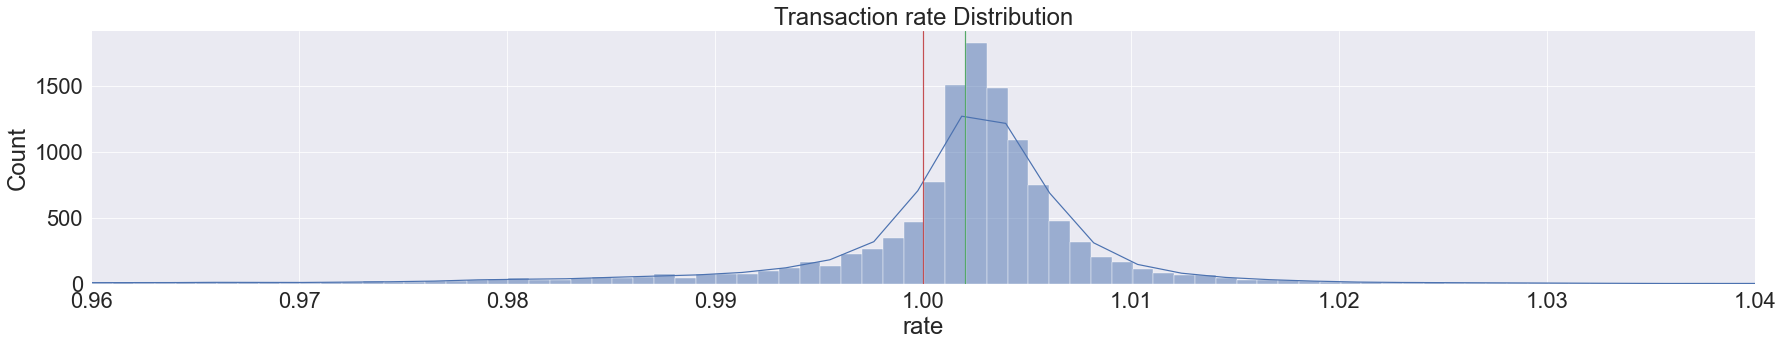

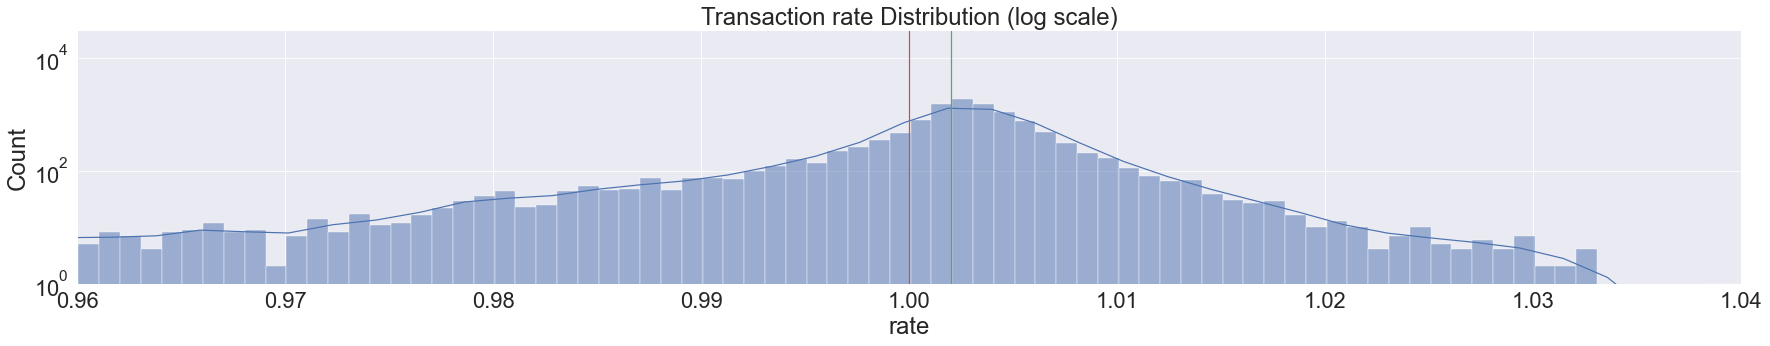

In [15]:
def draw_distribution(rates):
    sns.displot(rates, x='rate',kde=True, aspect=5, binwidth=.001).set(xlim=(.96, 1.04), title='Transaction rate Distribution')
    plt.axvline(x=1., color='r')
    plt.axvline(x=1.002, color='g')
    sns.displot(rates, x='rate',kde=True, aspect=5, binwidth=.001).set(ylim=(1,30000), xlim=(.96, 1.04), title='Transaction rate Distribution (log scale)', yscale='log')
    plt.axvline(x=1., color='r')
    plt.axvline(x=1.002, color='g')
    number_of_transactions = len(rates)
    transactions_1 = len(rates[rates['rate'] > 1]) / number_of_transactions
    transactions_1002 = len(rates[rates['rate'] > 1.002]) / number_of_transactions
    print(f'We made {number_of_transactions} transactions\n{100*transactions_1:.2f}% above rate 1.\n{100*transactions_1002:.2f}% above rate 1.002')
    plt.show()
draw_distribution(pd.DataFrame([transaction.rate for transaction in stock.transactions], columns=['rate']))

### After analyzing the last million minutes of prices (almost two years), we collected 11 926 potential trades to work with. The charts above show how their profitability is distributed.

### At first glance, the strategy seems to be correct. 76.88% of trades are profitable, which should translate into final money gain. Unfortunately, an ordinary exchange user is charged a 0.1% fee for each operation, which translates into almost 0.2% loss on one transaction (then only 58.42% of 'em give profits). In the second chart, we also see that more trades give big losses than big gains, which ultimately translates into the fact that if we want to make a profit, correct purchases must be well over 50%.

## **Collecting data**
###We will save each transaction that we make with the basic algorithm. Relevant information is the history of the stock exchange before making a decision (along with indicators) and of course profitability of a given operation. We decided to observe last 50 minutes of such indicators as:
*   price
*   moving averages for the last 16, 64, 256 and 1024 readings
*   lower Bollinger band for the last 20 and 256 readings


### To keep the chart clean, it does not show all recorded parameters.




In [16]:
Window(stock.transactions[-1]).normalize().draw()

##**Splitting data**
### We are going to divide the collected data into sets:
*   training   - 60%
*   validation - 20%
*   test       - 20%

Training dataset are examples that we will use for our learning process. Each classifier will use the same training set, which will allow us to easily compare the results. The validation set will be used to optimize parameters of specific classifiers. Finally, the test set will allow us to rank and compare all of the used methods.




In [17]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

ml_data = get_data_for_ML(stock).dropna()

# y = ml_data[[0]].rename(columns={0:'Result'}).Result
y = ml_data[0]
X = ml_data[list(range(1,351))]
rate_in_out = ml_data[[351,352,353]].rename(columns={351:'rate', 352:'index_in', 353:'index_out'})

X_train, X_test, y_train, y_test, rate_in_out_train, rate_in_out_test = train_test_split(X, y, rate_in_out, test_size=0.2, shuffle=False)

X_train, X_val, y_train, y_val, rate_in_out_train, rate_in_out_val = train_test_split(X_train, y_train, rate_in_out_train, test_size=0.25, shuffle=False)
X_train_xgb = X_train.copy()
X_val_xgb = X_val.copy()
X_test_xgb = X_test.copy()
y_train_original = [True] * len(y_train)
y_val_original = [True] * len(y_val)
y_test_original = [True] * len(y_test)
rate_in_out_train_xgb = rate_in_out_train
rate_in_out_test_xgb = rate_in_out_test
rate_in_out_val_xgb = rate_in_out_val

print("Train dataset size:       ", len(X_train), len(rate_in_out_train))
print("Validation dataset size:  ", len(X_val), len(rate_in_out_val))
print("Test dataset size:        ", len(X_test), len(rate_in_out_test))

Train dataset size:        7155 7155
Validation dataset size:   2385 2385
Test dataset size:         2386 2386


In [18]:
X_train_xgb_svm = X_train.copy()
X_val_xgb_svm = X_val.copy()
X_test_xgb_svm = X_test.copy()

##**Classifier rating**
###We will look at the classifiers on the basis of measures such as:
*   accuracy score
*   precision score
*   recall score
*   ROC AUC score
*   confusion matrix

###The most important factor is precision, because high precision guarantees a low percentage of transactions generating losses. Quality of decisions is far more important than quantity.









In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, make_scorer
from termcolor import colored
from sklearn.metrics import plot_precision_recall_curve

# def print_score(y_test, y_test_pred, dataset_name=''):
def print_score(data):
    y_test = eval(f'y_{data}')
    y_test_pred = eval(f'y_{data}_pred')
    y_original = eval(f'y_{data}_original')
    rate_in_out = eval(f'rate_in_out_{data}')
    def my_print(name):
        f = eval(name + '_score')
        print(f'{name:<17}\t{100*f(y_test,y_test_pred):.2f}%\t\t{100*f(y_test, y_original):.2f}%')
      
    print()
    print(colored(("\t\t\t" + data + "\t\tBollinger"), 'red'))
    my_print('accuracy')
    my_print('precision')
    my_print('recall')
    my_print('roc_auc')
    print("confusion matrix ", confusion_matrix(y_test, y_test_pred)[0], confusion_matrix(y_test, y_original)[0], sep='\t')
    print("                 ", confusion_matrix(y_test, y_test_pred)[1], confusion_matrix(y_test, y_original)[1], sep='\t')
    print('money (comission=0)', 
          f'{money_counter(y_test_pred, rate_in_out):.2f}$\t\t', 
          f'{money_counter(y_original, rate_in_out):.2f}$\t\t', 
          sep='\t')
    print('money (comission=.002)', 
          f'{money_counter(y_test_pred, rate_in_out, commission=.998):.2f}$\t\t', 
          f'{money_counter(y_original, rate_in_out, commission=.998):.2f}$\t\t', sep='\t')
    print('max loss\t', f'{100*get_max_loss(y_test_pred, rate_in_out):.2f}%', sep='\t')
    print()
def print_scores():
    print_score('train')
    
    print_score('val')
    print_score('test')

In [414]:
def draw_ml_distribution():
    draw_distribution(rate_in_out_val[y_val_pred])

def draw_roc_auc():
    from sklearn.metrics import roc_curve, auc

    fpr, tpr, roc_auc = {}, {}, {}
    fpr[1], tpr[1], _ = roc_curve(y_val, y_val_pred)
    roc_auc[1] = auc(fpr[1], tpr[1])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_val, y_val_pred)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    plt.figure()
    lw = 2
    plt.plot(fpr[1], tpr[1], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.figure(figsize=(20,10))
    plt.show()
    
def draw_rate_proba_scatter(proba, rate):
    plt.scatter(x=proba, y=rate['rate'])
    plt.title('Predictions rate distribution')
    plt.xlabel('probability')
    plt.ylabel('transaction rate')
    plt.figure(figsize=(20,10))
    plt.show()
    
def draw_money(proba):
    f = lambda p : money_counter((proba > p).astype(bool), rate_in_out_val, commission=.998)
#     f = lambda p : money_counter((np.vectorize(lambda p1 : p < p1  <= p+.1)(proba)).astype(bool), rate_in_out_val, commission=.998)
    probs = [p/100 for p in range(50,100)]
    plt.plot(probs, list(map(f, probs)))
    plt.title('Predictions rate distribution')
    plt.xlabel('probability boundary')
    plt.ylabel('money earned rate')
    plt.figure(figsize=(20,10))
    plt.show()


@timeit
def thresh_loss(clf, data='', step_t=.01, step_l=.01, begin_t=60, end_t=80, begin_l=70, end_l=100):
    X_data = eval(f'X_{data}')
    rate_in_out_data = eval(f'rate_in_out_{data}')
    thresholds = [t/100 for t in range(begin_t,end_t+1,int(100*step_t))]
    losses = [l/100 for l in range(begin_l,end_l+1,int(100*step_l))]
    moenys = []
    xpos = sorted(thresholds * len(losses))
    ypos = losses * len(thresholds)
    y_pred = clf.predict_proba(X_data)[:,1]
    for threshold in thresholds:
        y_data_pred = (threshold <= y_pred).astype(bool)
        for loss in losses:
            df = stop_loss(y_data_pred, rate_in_out_data, loss)
            mc = money_counter(y_data_pred, df, .998)
            moenys.append(mc)
    return xpos, ypos, moenys

def draw_thresh_loss_money(*args):
    trace = go.Scatter3d(
        x=args[0],
        y=args[1],
        z=args[2],
        mode='markers',
        marker={
            'size': 10,
            'opacity': 0.8,
        }
    )

    layout = go.Layout(
        margin={'l': 0, 'r': 0, 'b': 0, 't': 0},
        scene = go.layout.Scene(
        xaxis=go.layout.scene.XAxis(title='probability threshold'),
        yaxis=go.layout.scene.YAxis(title='stoploss'),
        zaxis=go.layout.scene.ZAxis(title='money rate')
        )
    )

    data = [trace]

    plot_figure = go.Figure(data=data, layout=layout)
    plot_figure.show()


def draw_money_history(*histories, legende=[]):
    colores = ['red', 'green', 'blue', 'cyan', 'grey', 'white']
    for history, color in zip(histories, colores):
        moeny, history = history
#         print(colored(f"We've ended up with {moeny:.2f} return", color))
        plt.plot(list(map(index_to_date, history.index_out)), history.rate)
    plt.xlabel('time')
    plt.ylabel('rate')
    plt.legend(legende)
    plt.title('Our transactions in time')
        

## **KNN**



			train		Bollinger
accuracy         	73.12%		49.38%
precision        	76.34%		49.38%
recall           	66.03%		100.00%
roc_auc          	73.04%		50.00%
confusion matrix 	[2899  723]	[   0 3622]
                 	[1200 2333]	[   0 3533]
money (comission=0)	9.33$			2.65$		
money (comission=.002)	0.96$			0.10$		
max loss		85.33%


			val		Bollinger
accuracy         	64.49%		50.73%
precision        	66.55%		50.73%
recall           	60.33%		100.00%
roc_auc          	64.55%		50.00%
confusion matrix 	[808 367]	[   0 1175]
                 	[480 730]	[   0 1210]
money (comission=0)	1.60$			1.32$		
money (comission=.002)	0.74$			0.40$		
max loss		76.03%


			test		Bollinger
accuracy         	61.02%		51.13%
precision        	63.68%		51.13%
recall           	55.33%		100.00%
roc_auc          	61.15%		50.00%
confusion matrix 	[781 385]	[   0 1166]
                 	[545 675]	[   0 1220]
money (comission=0)	1.84$			2.00$		
money (comission=.002)	0.87$			0.63$		
max loss		92.95%

We made 1097 trans

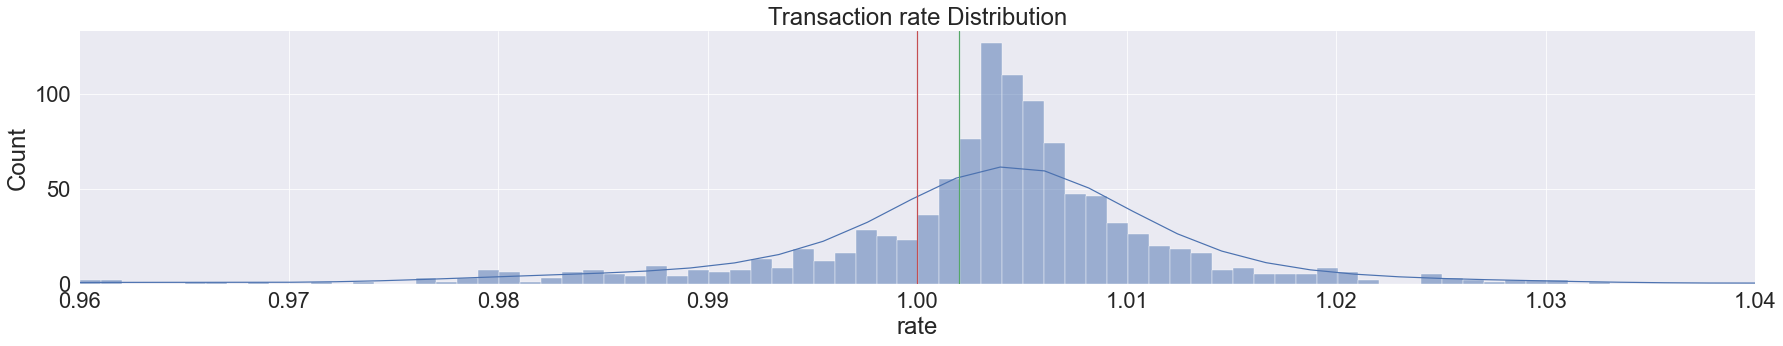

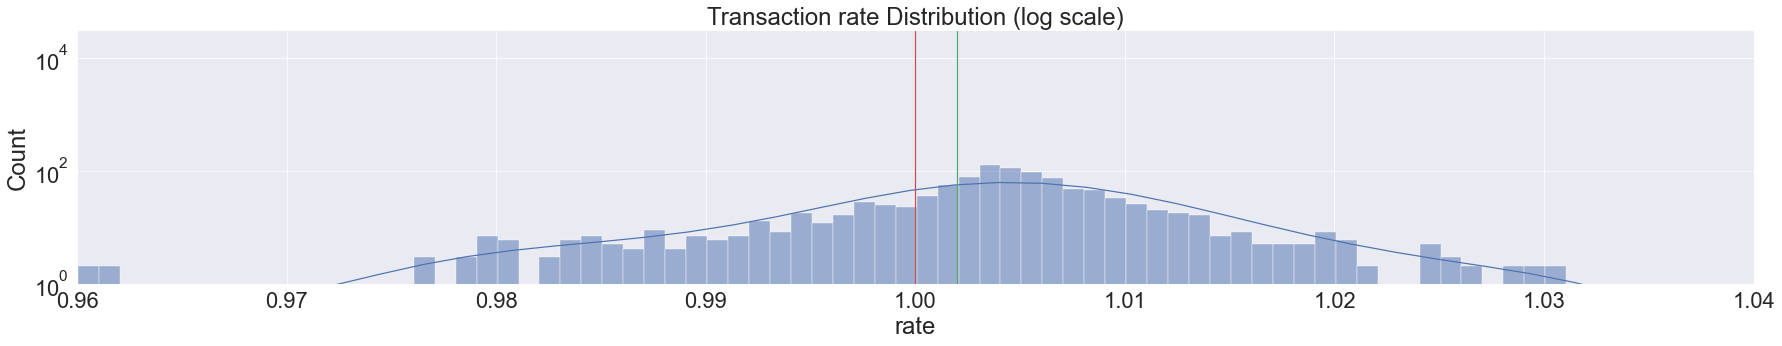

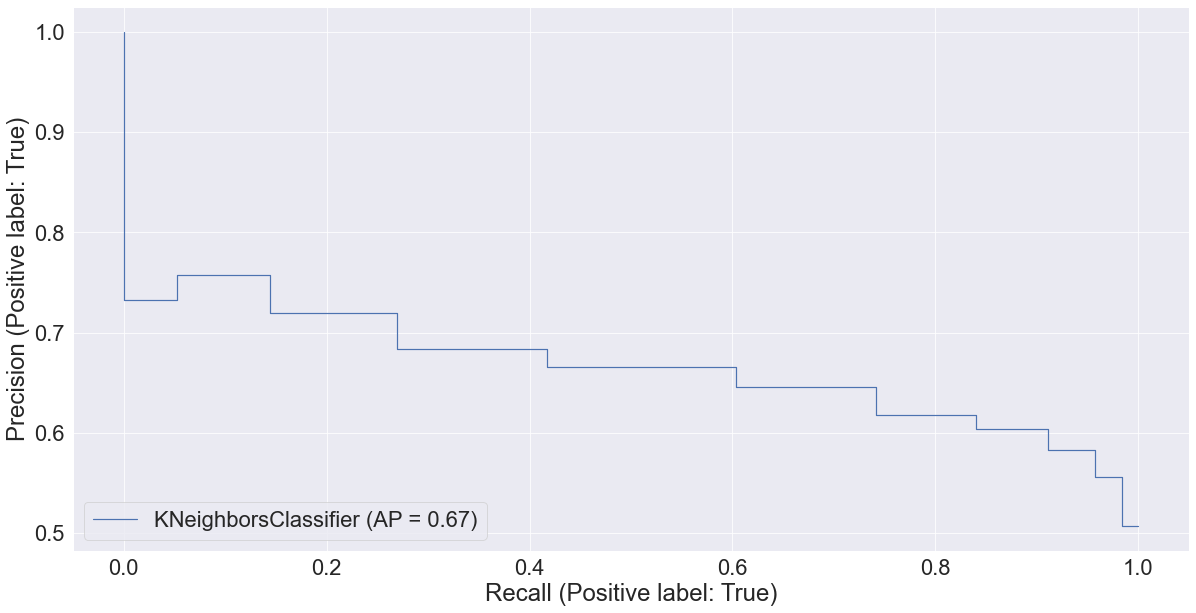

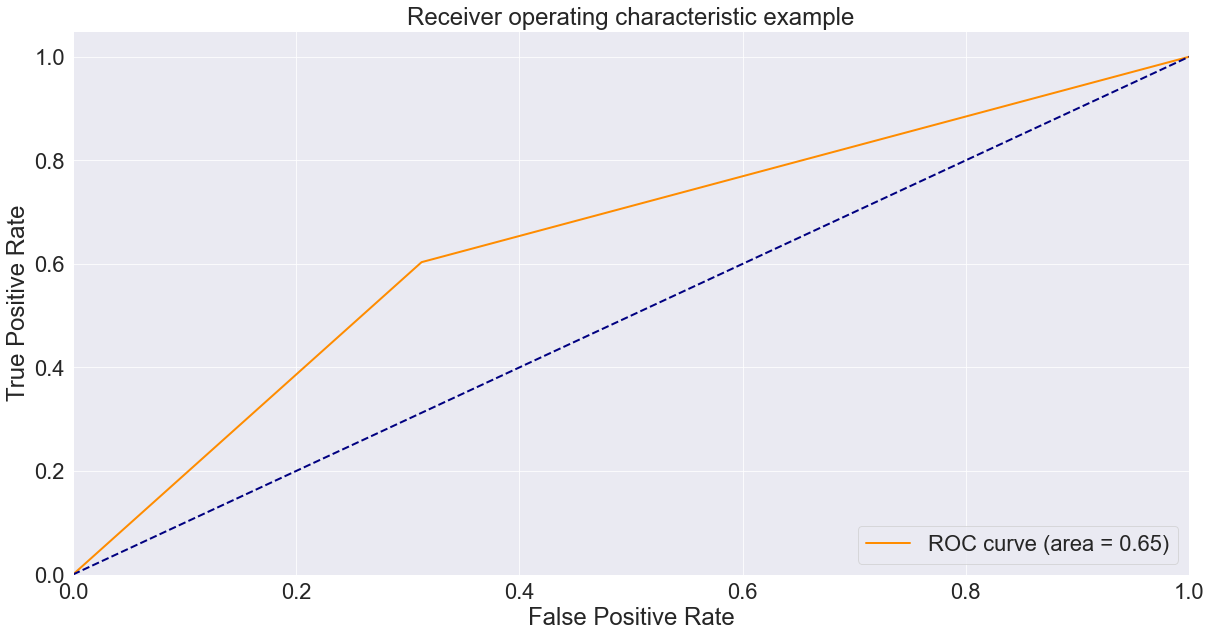

<Figure size 1440x720 with 0 Axes>

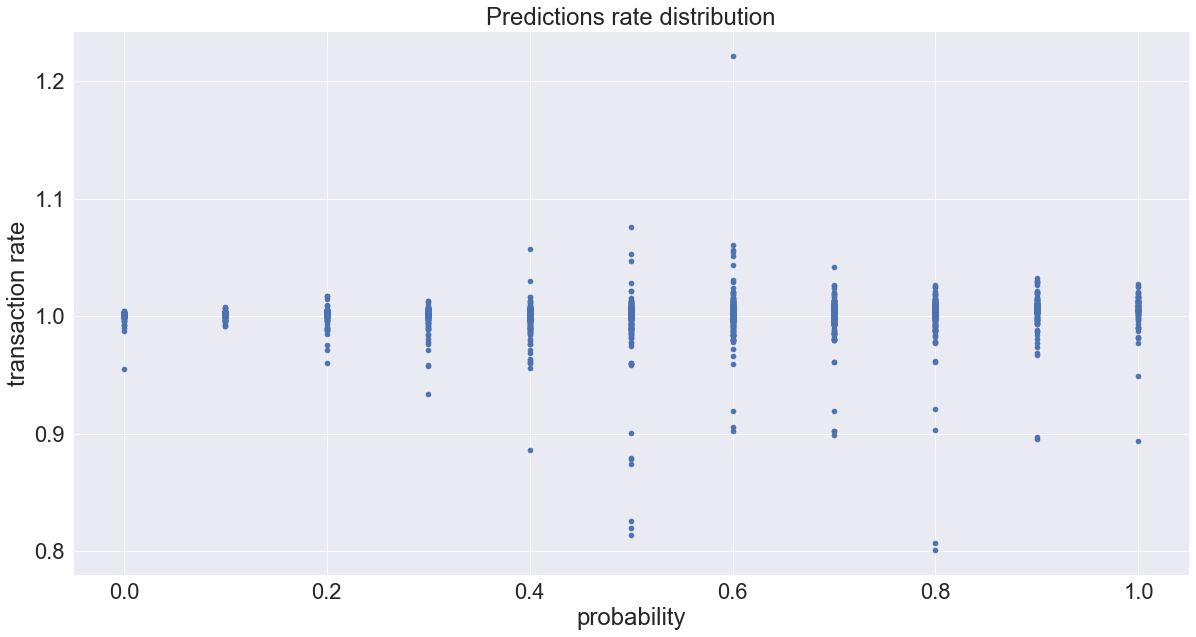

<Figure size 1440x720 with 0 Axes>

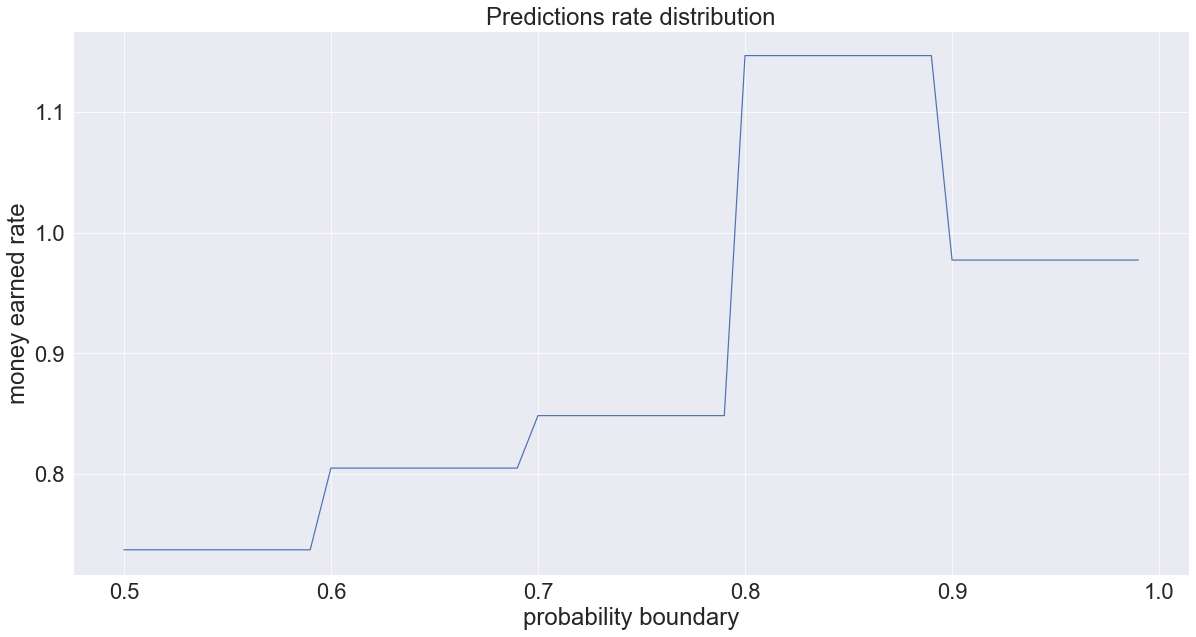

<Figure size 1440x720 with 0 Axes>

In [21]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=10)
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
y_val_pred = clf.predict(X_val)

print_scores()
draw_ml_distribution()
plot_precision_recall_curve(clf, X_val, y_val)
draw_roc_auc()
draw_rate_proba_scatter(clf.predict_proba(X_val)[:,1], rate_in_out_val)
draw_money(clf.predict_proba(X_val)[:,1])

In [22]:
threshold = .9
y_train_pred = (np.vectorize(lambda p : threshold <= p)(clf.predict_proba(X_train)[:,1])).astype(bool)
y_test_pred = (np.vectorize(lambda p : threshold <= p)(clf.predict_proba(X_test)[:,1])).astype(bool)
y_val_pred = (np.vectorize(lambda p : threshold <= p)(clf.predict_proba(X_val)[:,1])).astype(bool)

print_scores()

y_train_pred_knn = y_train_pred.copy()
y_val_pred_knn = y_val_pred.copy()
y_test_pred_knn = y_test_pred.copy()

# stop_loss <= 85%, threshold : .9 <= p
knn = clf


			train		Bollinger
accuracy         	57.92%		49.38%
precision        	95.31%		49.38%
recall           	15.54%		100.00%
roc_auc          	57.40%		50.00%
confusion matrix 	[3595   27]	[   0 3622]
                 	[2984  549]	[   0 3533]
money (comission=0)	5.94$			2.65$		
money (comission=.002)	3.05$			0.10$		
max loss		92.17%


			val		Bollinger
accuracy         	54.26%		50.73%
precision        	75.76%		50.73%
recall           	14.46%		100.00%
roc_auc          	54.85%		50.00%
confusion matrix 	[1119   56]	[   0 1175]
                 	[1035  175]	[   0 1210]
money (comission=0)	1.49$			1.32$		
money (comission=.002)	1.15$			0.40$		
max loss		85.10%


			test		Bollinger
accuracy         	52.18%		51.13%
precision        	73.10%		51.13%
recall           	10.25%		100.00%
roc_auc          	53.15%		50.00%
confusion matrix 	[1120   46]	[   0 1166]
                 	[1095  125]	[   0 1220]
money (comission=0)	1.31$			2.00$		
money (comission=.002)	1.06$			0.63$		
max loss		93.07%



In [284]:
result = thresh_loss(clf, 'val', step_t=.1, step_l=.01, begin_t=60, end_t=100, begin_l=70, end_l=100)
draw_thresh_loss_money(*result)

Time of execution : 41.39 seconds


##**Logistic Regression**


			train		Bollinger
accuracy         	59.85%		49.38%
precision        	63.83%		49.38%
recall           	43.11%		100.00%
roc_auc          	59.64%		50.00%
confusion matrix 	[2759  863]	[   0 3622]
                 	[2010 1523]	[   0 3533]
money (comission=0)	2.63$			2.65$		
money (comission=.002)	0.60$			0.10$		
max loss		79.99%


			val		Bollinger
accuracy         	64.53%		50.73%
precision        	68.20%		50.73%
recall           	56.36%		100.00%
roc_auc          	64.65%		50.00%
confusion matrix 	[857 318]	[   0 1175]
                 	[528 682]	[   0 1210]
money (comission=0)	1.12$			1.32$		
money (comission=.002)	0.63$			0.40$		
max loss		69.77%


			test		Bollinger
accuracy         	59.72%		51.13%
precision        	64.06%		51.13%
recall           	48.36%		100.00%
roc_auc          	59.99%		50.00%
confusion matrix 	[835 331]	[   0 1166]
                 	[630 590]	[   0 1220]
money (comission=0)	1.59$			2.00$		
money (comission=.002)	0.94$			0.63$		
max loss		92.95%

We made 1000 trans

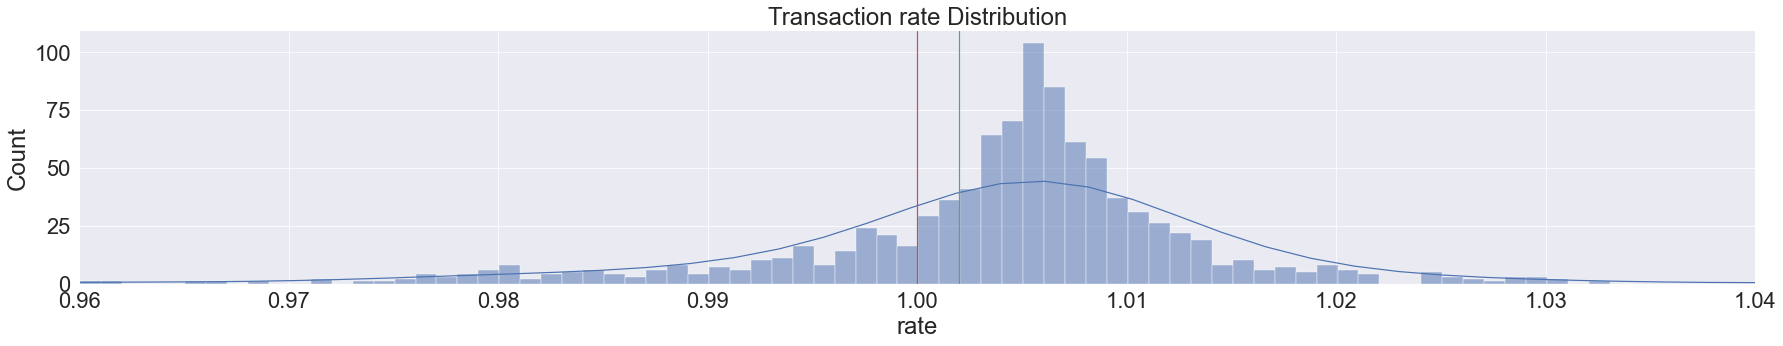

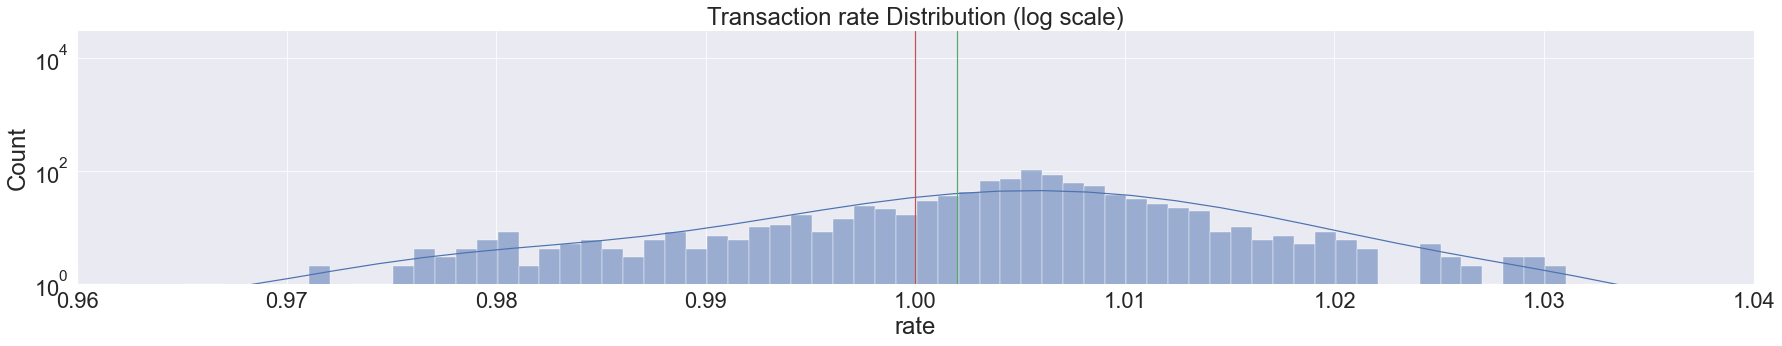

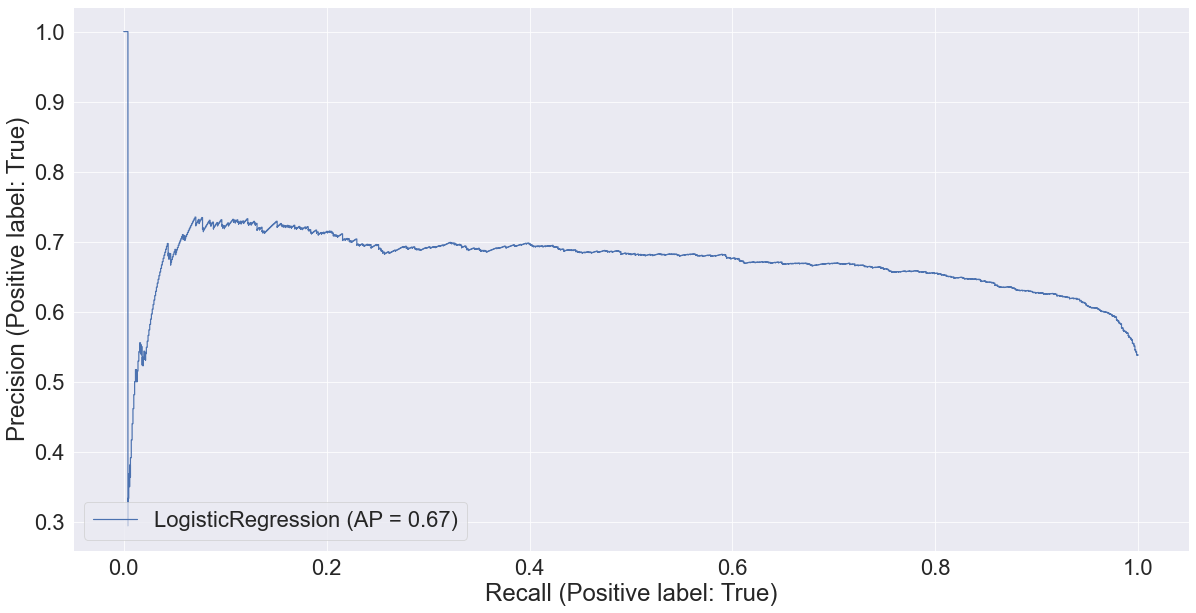

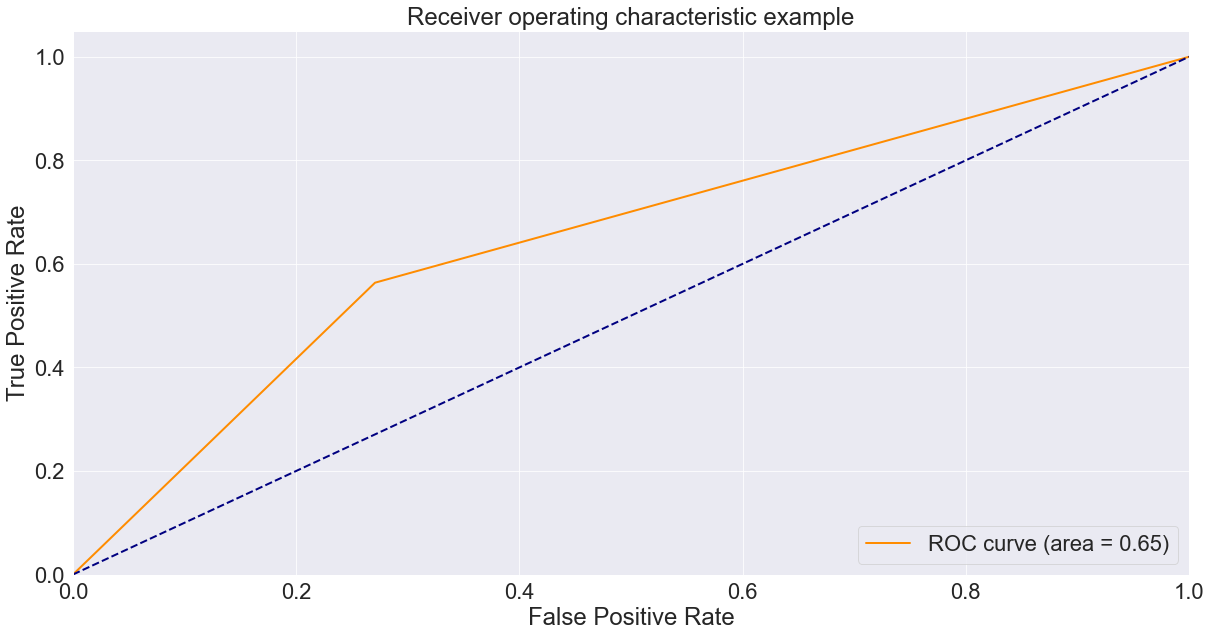

<Figure size 1440x720 with 0 Axes>

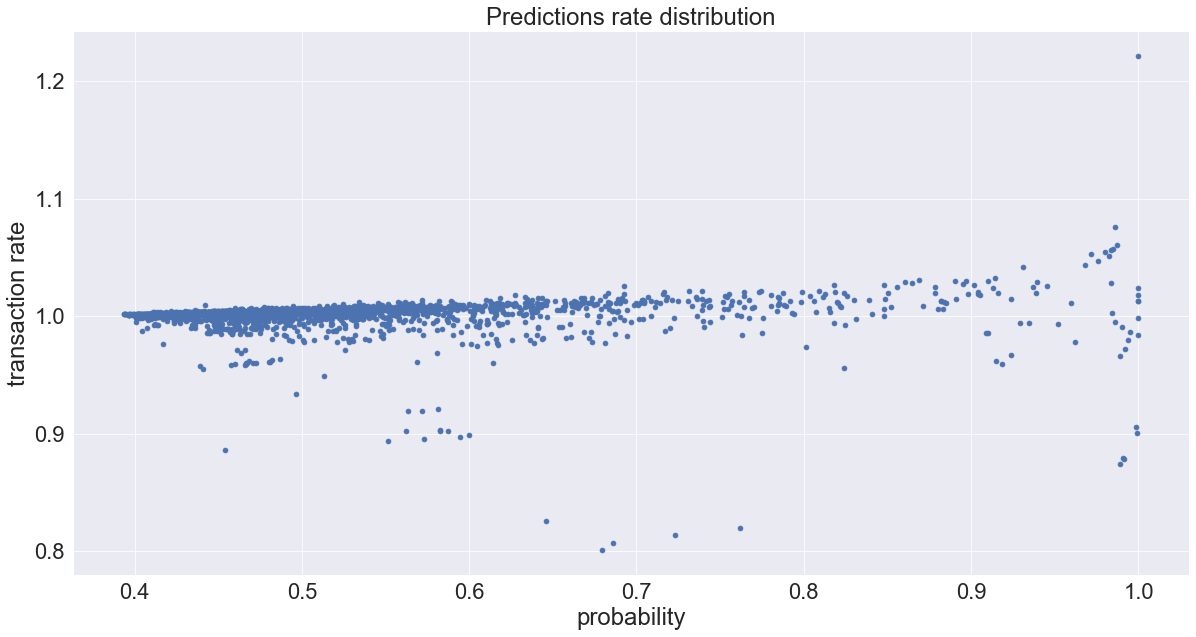

<Figure size 1440x720 with 0 Axes>

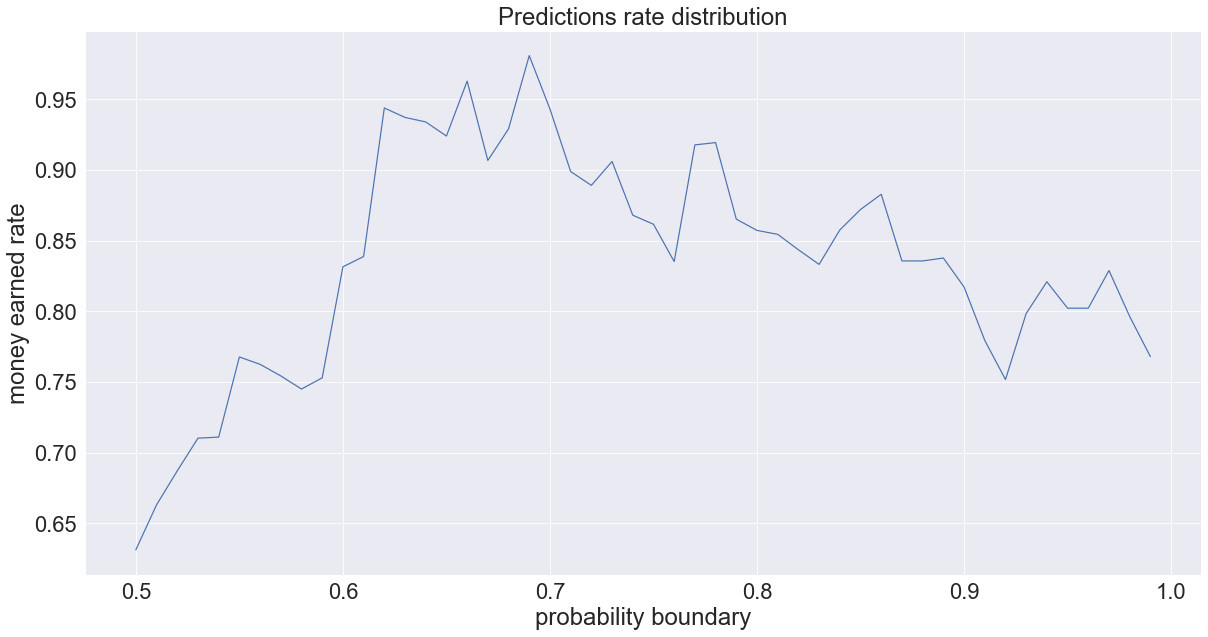

<Figure size 1440x720 with 0 Axes>

In [23]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(class_weight='balanced', penalty='l2')
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
y_val_pred = clf.predict(X_val)

print_scores()
draw_ml_distribution()
plot_precision_recall_curve(clf, X_val, y_val)
draw_roc_auc()
draw_rate_proba_scatter(clf.predict_proba(X_val)[:,1], rate_in_out_val)
draw_money(clf.predict_proba(X_val)[:,1])

log_reg = clf

In [286]:
result = thresh_loss(clf, 'val', step_t=.01, step_l=.01, begin_t=60, end_t=100, begin_l=70, end_l=100)
draw_thresh_loss_money(*result)

Time of execution : 89.63 seconds


In [288]:
result = thresh_loss(clf, 'test', step_t=.01, step_l=.01, begin_t=60, end_t=100, begin_l=70, end_l=100)
draw_thresh_loss_money(*result)

Time of execution : 38.2 seconds


In [24]:
X_train_xgb[352] = clf.predict_proba(X_train)[:,1]
X_test_xgb[352] = clf.predict_proba(X_test)[:,1]
X_val_xgb[352] = clf.predict_proba(X_val)[:,1]

## **XGBoost**


			train		Bollinger
accuracy         	66.46%		49.38%
precision        	63.07%		49.38%
recall           	77.36%		100.00%
roc_auc          	66.59%		50.00%
confusion matrix 	[2022 1600]	[   0 3622]
                 	[ 800 2733]	[   0 3533]
money (comission=0)	3.38$			2.65$		
money (comission=.002)	0.31$			0.10$		
max loss		79.99%


			val		Bollinger
accuracy         	69.39%		50.73%
precision        	66.15%		50.73%
recall           	81.24%		100.00%
roc_auc          	69.22%		50.00%
confusion matrix 	[672 503]	[   0 1175]
                 	[227 983]	[   0 1210]
money (comission=0)	1.19$			1.32$		
money (comission=.002)	0.51$			0.40$		
max loss		69.77%


			test		Bollinger
accuracy         	59.72%		51.13%
precision        	64.06%		51.13%
recall           	48.36%		100.00%
roc_auc          	59.99%		50.00%
confusion matrix 	[835 331]	[   0 1166]
                 	[630 590]	[   0 1220]
money (comission=0)	1.59$			2.00$		
money (comission=.002)	0.94$			0.63$		
max loss		92.95%

We made 1486 trans

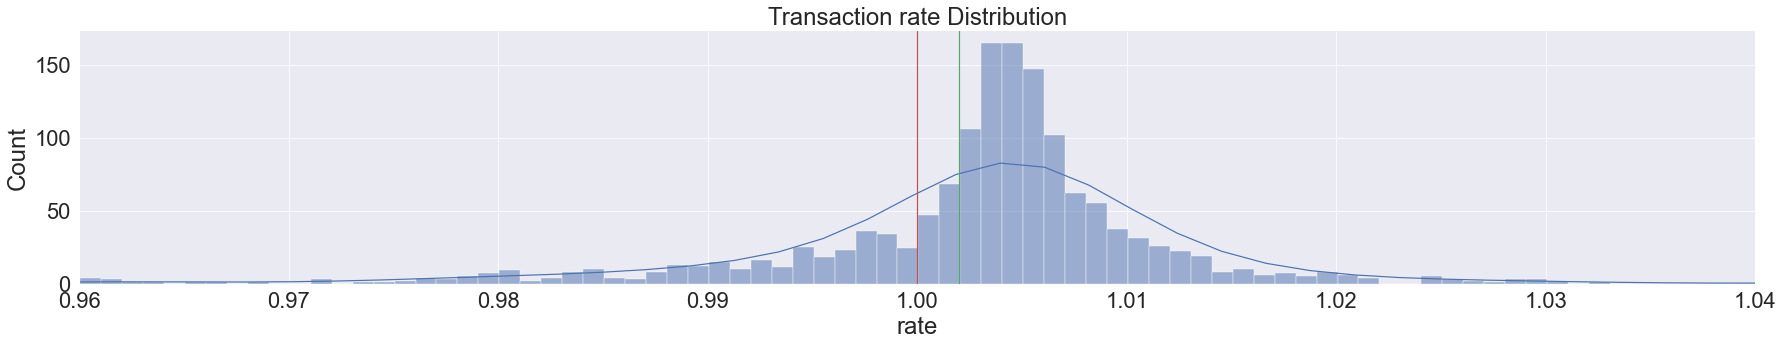

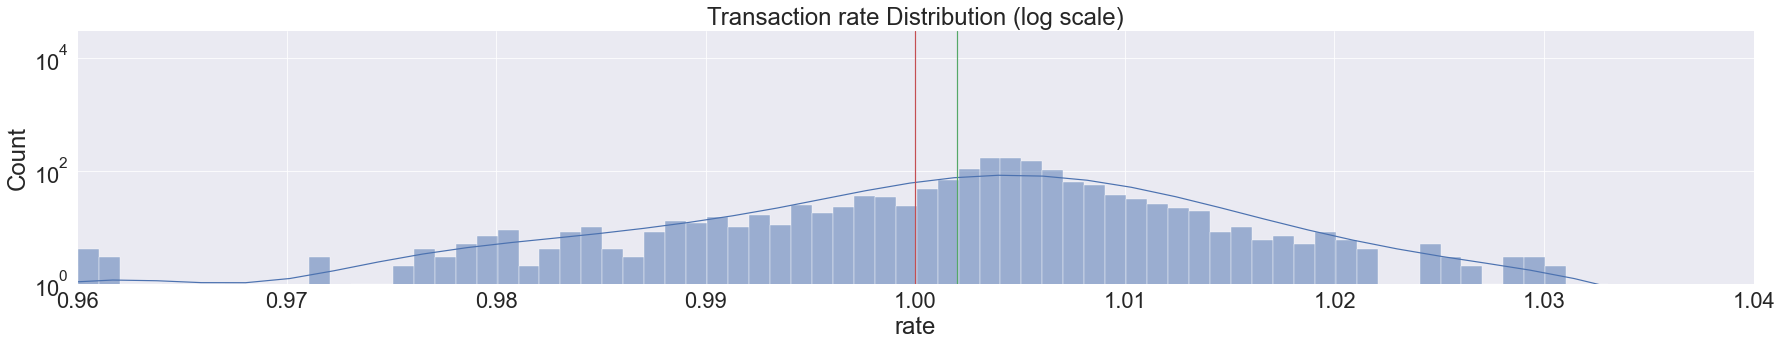

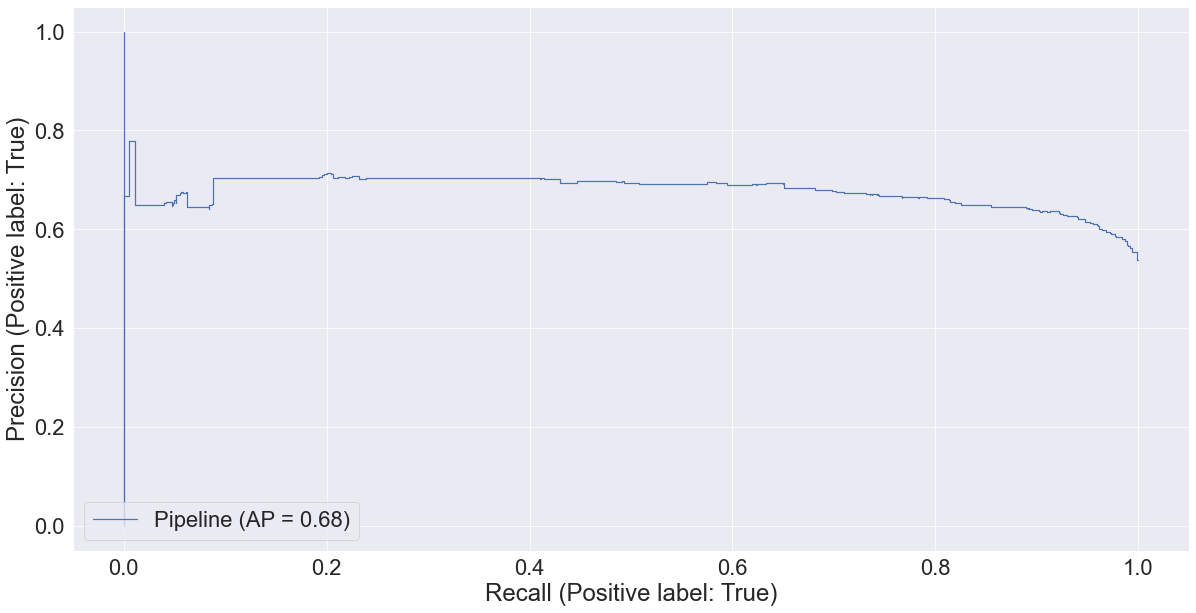

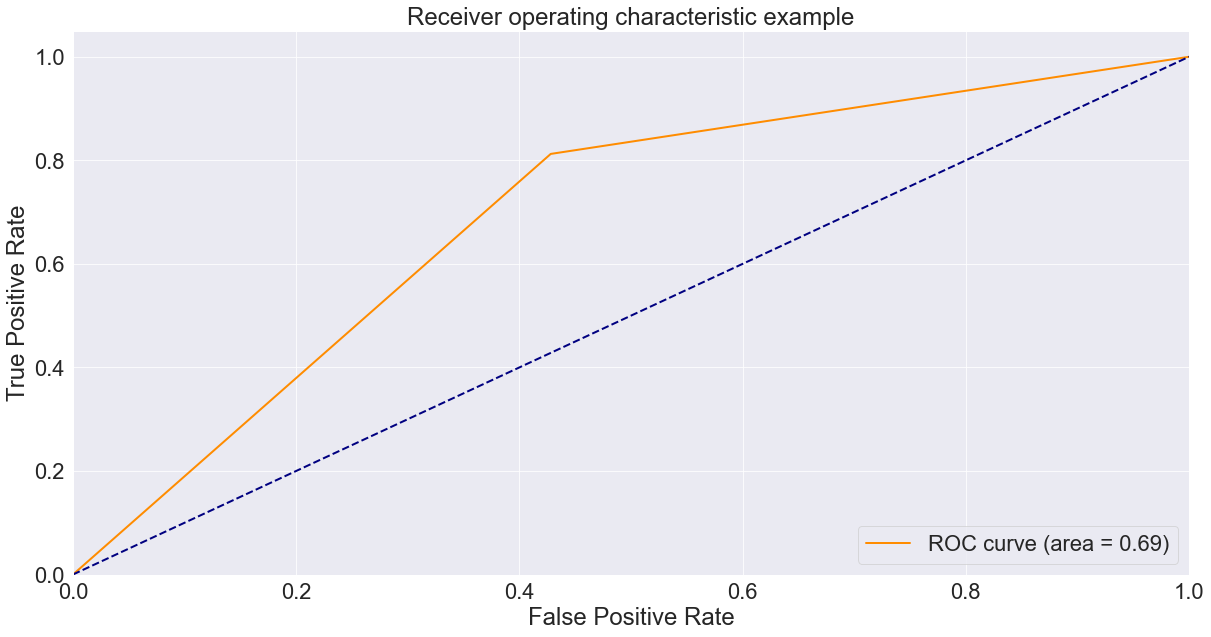

<Figure size 1440x720 with 0 Axes>

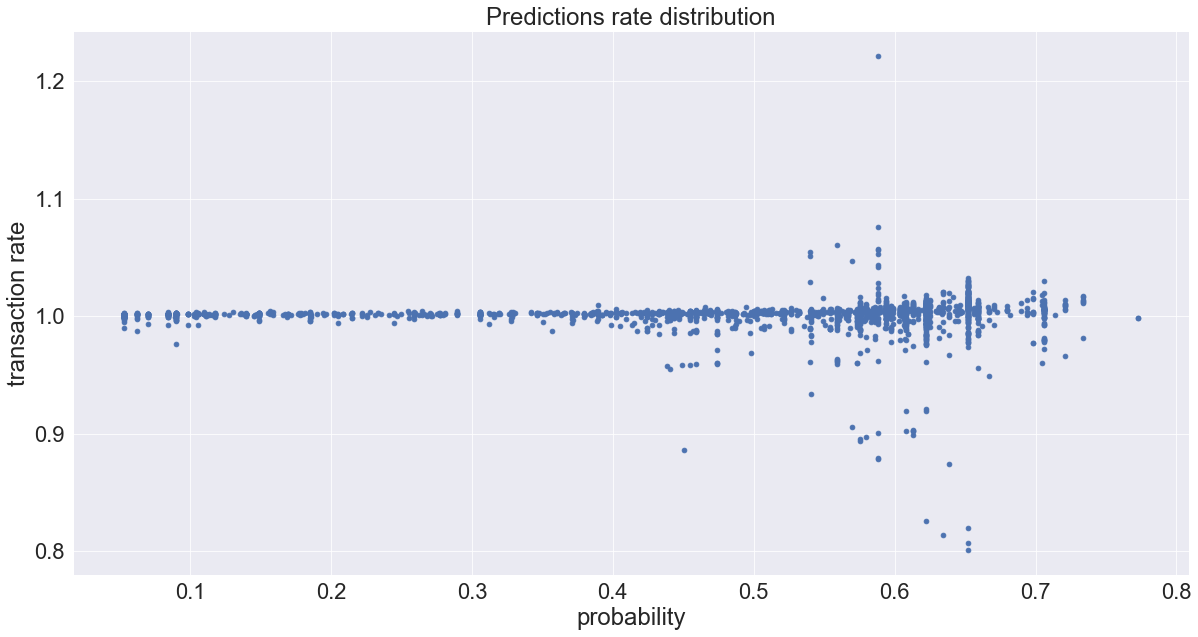

<Figure size 1440x720 with 0 Axes>

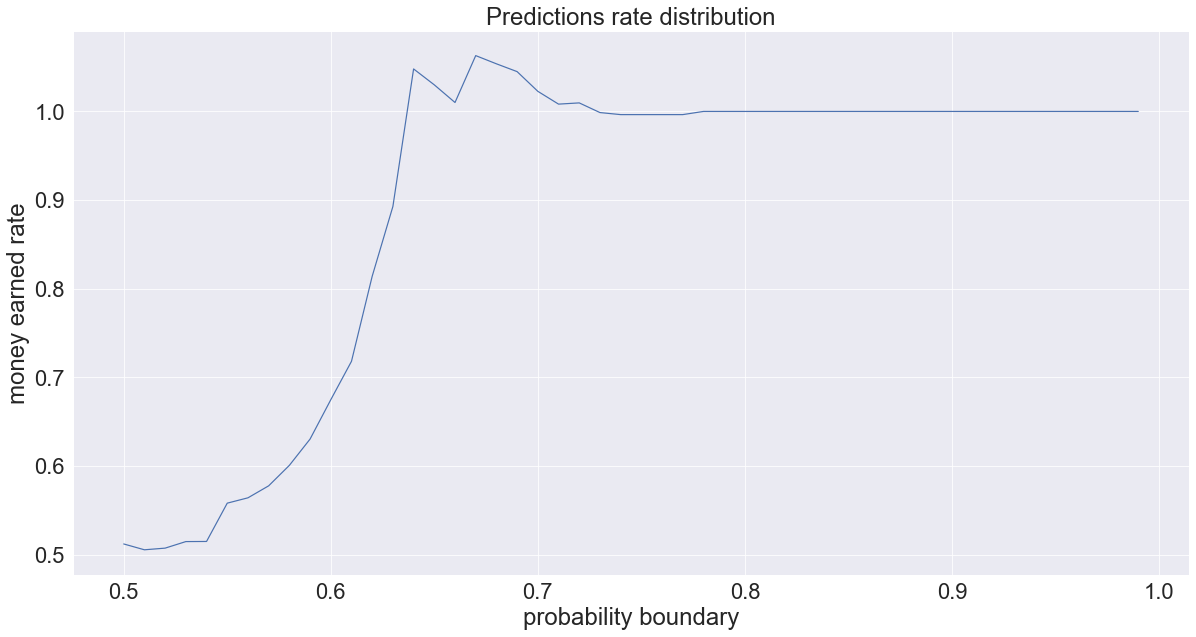

<Figure size 1440x720 with 0 Axes>

In [25]:
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
scale_pos_weight = ( len(y_train) - sum(y_train) )/ sum(y_train)
clf = Pipeline([('scaler', StandardScaler()), 
                 ('xgb', XGBClassifier(max_depth=4, gamma=15,reg_lambda=.1, use_label_encoder=False, eval_metric='logloss'))])

clf.fit(X_train, y_train)

y_train_pred = (clf.predict_proba(X_train)[:,1] >= 0.5).astype(bool)
y_val_pred = (clf.predict_proba(X_val)[:,1] >= 0.5).astype(bool)
print_scores()
draw_ml_distribution()
plot_precision_recall_curve(clf, X_val, y_val)
draw_roc_auc()
draw_rate_proba_scatter(clf.predict_proba(X_val)[:,1], rate_in_out_val)
draw_money(clf.predict_proba(X_val)[:,1])

In [291]:
result = thresh_loss(clf, 'val', step_t=.01, step_l=.01, begin_t=60, end_t=100, begin_l=70, end_l=100)
draw_thresh_loss_money(*result)

Time of execution : 78.87 seconds


In [85]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[4,6,8,10], 'gamma':[.5, 5, 15], 'reg_lambda':[.1, 1, 5], 'learning_rate':[.3,.7]}
clf = GridSearchCV(XGBClassifier(n_estimators=8, use_label_encoder=False, eval_metric='logloss'), parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     eval_metric='logloss', gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=8, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
               

In [112]:
clf.best_params_

{'gamma': 15.2, 'learning_rate': 0.3, 'max_depth': 4, 'reg_lambda': 0.1}

In [103]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[4], 'gamma':[14.8, 15, 15.2], 'reg_lambda':[.1, .12, .15, .17], 'learning_rate':[.3]}
clf = GridSearchCV(XGBClassifier(n_estimators=8, use_label_encoder=False, eval_metric='logloss'), parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     eval_metric='logloss', gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=8, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
               

In [113]:
clf.cv_results_

{'mean_fit_time': array([0.65236506, 0.64313045, 0.63692603, 0.9227881 , 0.95371404,
        0.95691299, 0.95222116, 0.98183446, 0.96038394, 0.93925633,
        0.93964725, 0.9483573 ]),
 'std_fit_time': array([0.04827858, 0.0063474 , 0.00327664, 0.13336919, 0.00948051,
        0.01224514, 0.00454096, 0.0207907 , 0.01444918, 0.00704068,
        0.00802826, 0.00259527]),
 'mean_score_time': array([0.02612948, 0.02755771, 0.02753911, 0.04095058, 0.03979692,
        0.04289255, 0.03989897, 0.04159961, 0.04288568, 0.03999524,
        0.0417912 , 0.04358563]),
 'std_score_time': array([0.00193371, 0.00164106, 0.00163951, 0.00195769, 0.00079995,
        0.00237816, 0.00220649, 0.00133709, 0.00199442, 0.00205283,
        0.00236997, 0.00097671]),
 'param_gamma': masked_array(data=[14.8, 14.8, 14.8, 14.8, 15, 15, 15, 15, 15.2, 15.2,
                    15.2, 15.2],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
     

In [37]:
# X_train_xgb.drop(351, axis=1, inplace=True)
# X_val_xgb.drop(351, axis=1, inplace=True)
# X_test_xgb.drop(351, axis=1, inplace=True)

XGBoost with logistic regression


			train		Bollinger
accuracy         	67.46%		49.38%
precision        	63.89%		49.38%
recall           	78.43%		100.00%
roc_auc          	67.60%		50.00%
confusion matrix 	[2056 1566]	[   0 3622]
                 	[ 762 2771]	[   0 3533]
money (comission=0)	3.36$			2.65$		
money (comission=.002)	0.30$			0.10$		
max loss		79.99%


			val		Bollinger
accuracy         	68.72%		50.73%
precision        	65.74%		50.73%
recall           	80.08%		100.00%
roc_auc          	68.55%		50.00%
confusion matrix 	[670 505]	[   0 1175]
                 	[241 969]	[   0 1210]
money (comission=0)	1.22$			1.32$		
money (comission=.002)	0.53$			0.40$		
max loss		69.77%


			test		Bollinger
accuracy         	59.72%		51.13%
precision        	64.06%		51.13%
recall           	48.36%		100.00%
roc_auc          	59.99%		50.00%
confusion matrix 	[835 331]	[   0 1166]
                 	[630 590]	[   0 1220]
money (comission=0)	1.59$			2.00$		
money (comission=.002)	0.94$			0.63$		
max loss		92.95%

We made 1474 trans

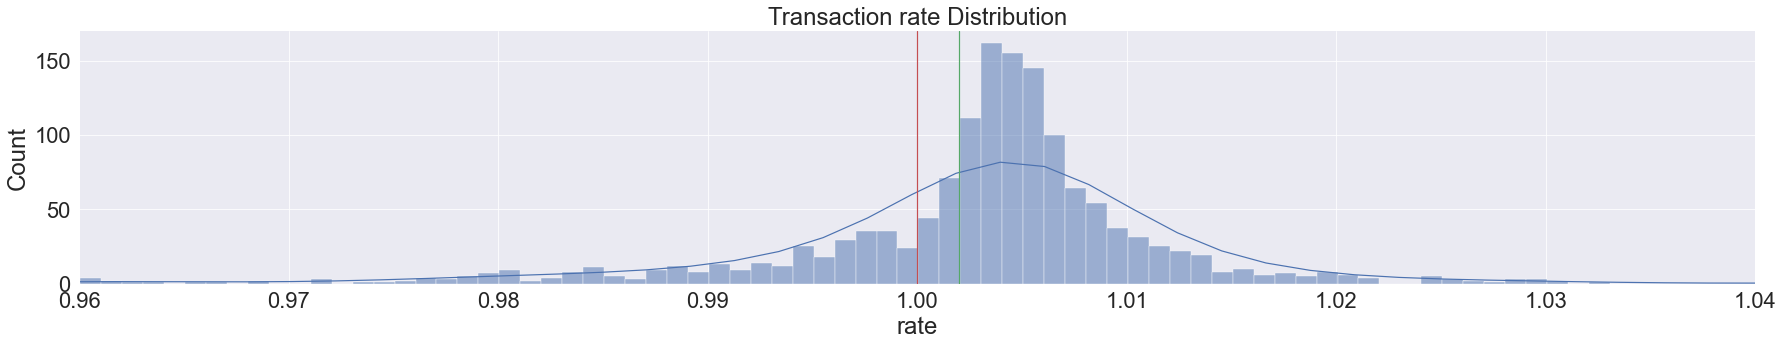

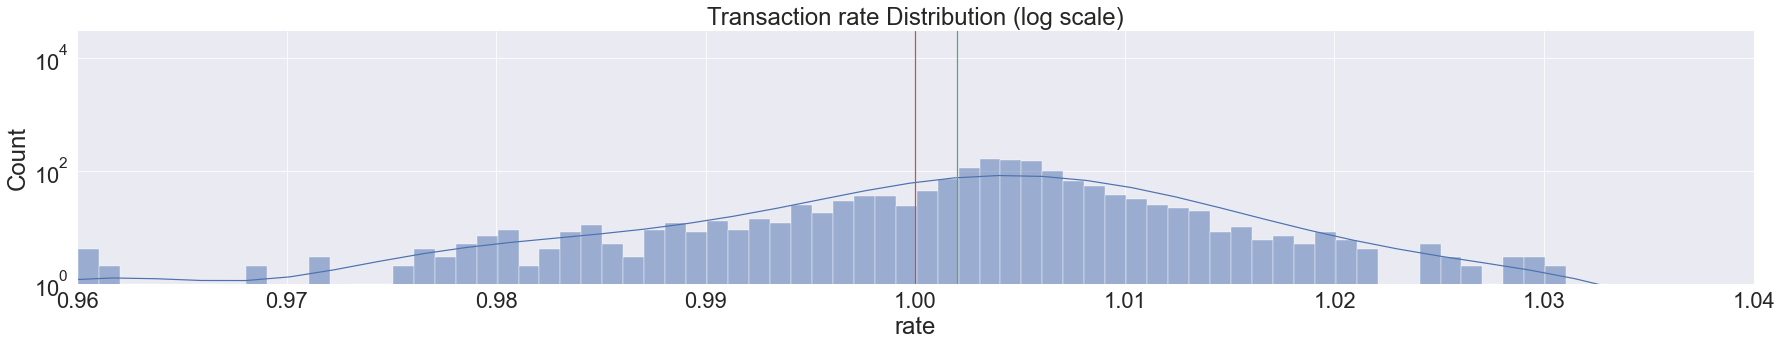

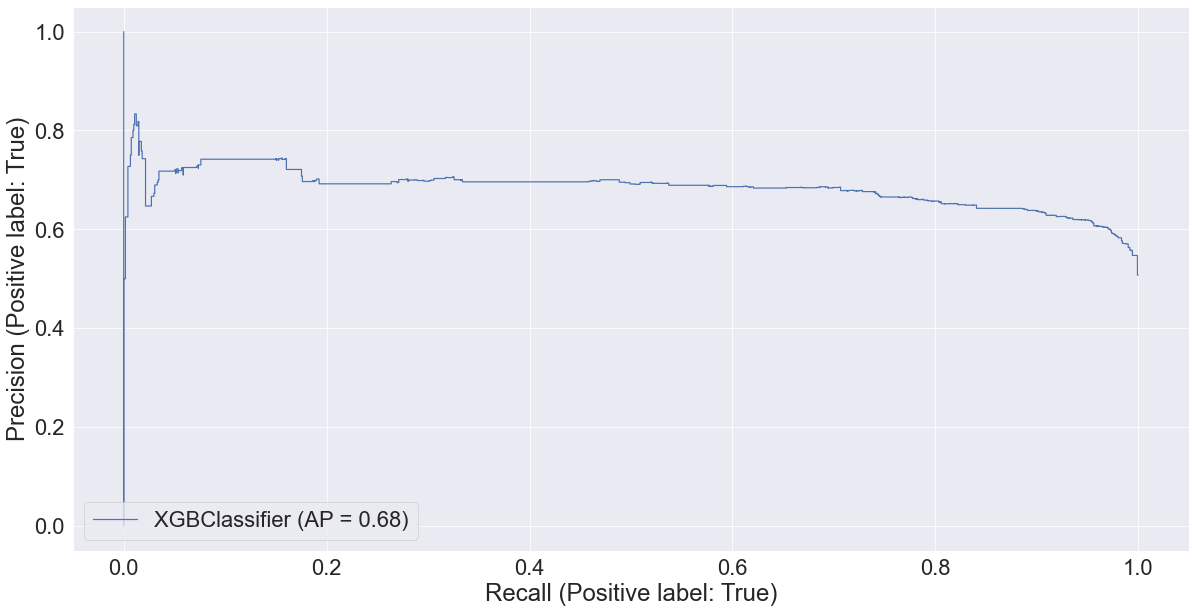

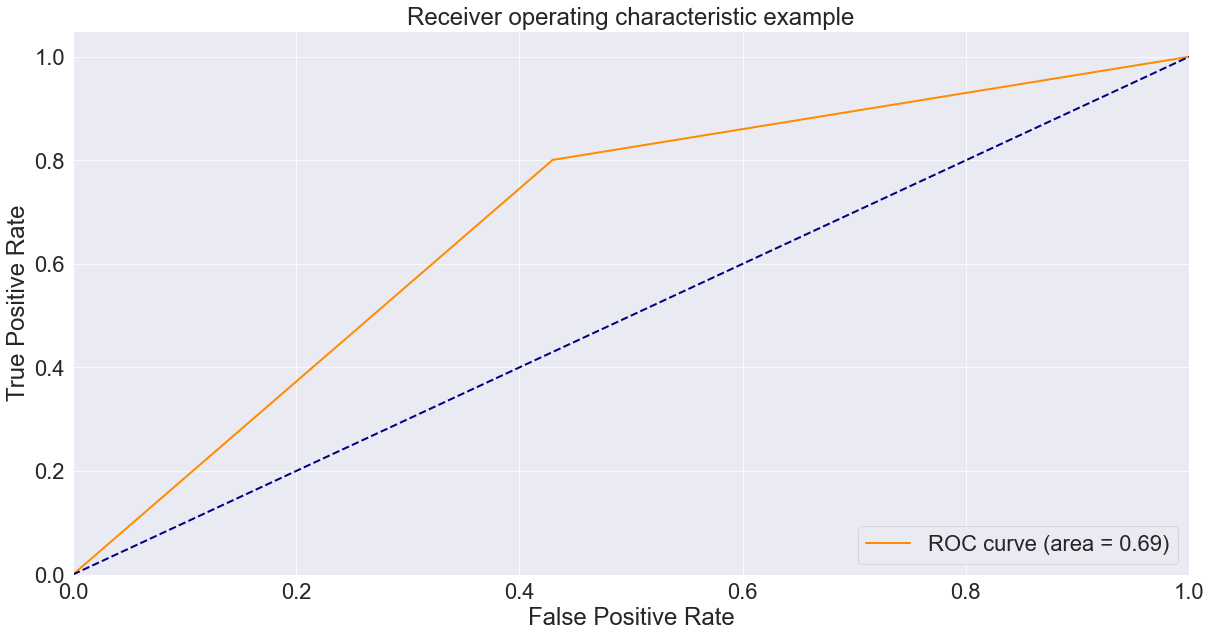

<Figure size 1440x720 with 0 Axes>

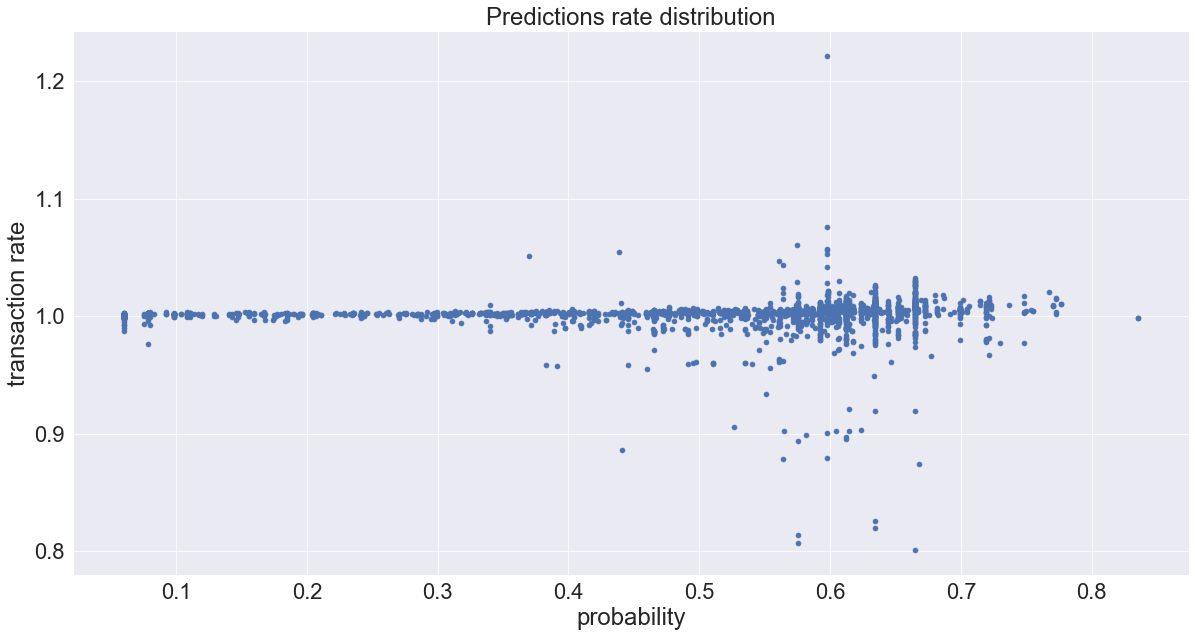

<Figure size 1440x720 with 0 Axes>

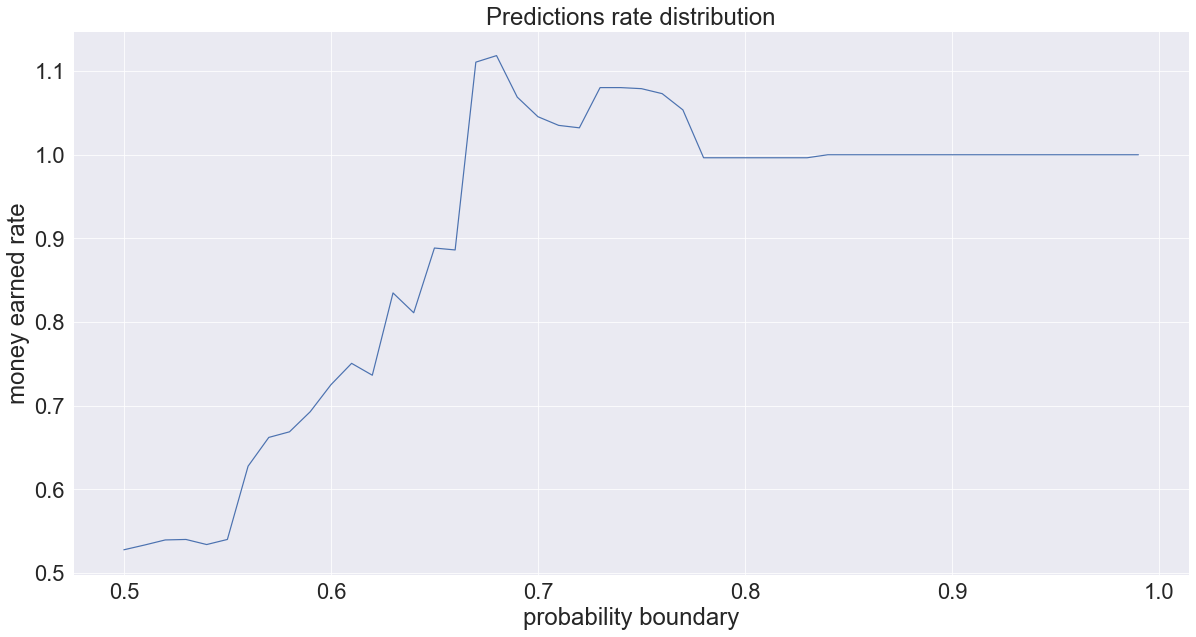

<Figure size 1440x720 with 0 Axes>

In [26]:
from xgboost import XGBClassifier
# clf = Pipeline([('scaler', StandardScaler()), 
#                  ('xgb', XGBClassifier(max_depth=4, gamma=15,reg_lambda=.1, use_label_encoder=False, eval_metric='logloss'))])
clf = XGBClassifier(max_depth=4, gamma=15,reg_lambda=.1, use_label_encoder=False, eval_metric='logloss')
clf.fit(X_train_xgb, y_train)

y_train_pred = (clf.predict_proba(X_train_xgb)[:,1] >= 0.5).astype(bool)
y_val_pred = (clf.predict_proba(X_val_xgb)[:,1] >= 0.5).astype(bool)
print_scores()
draw_ml_distribution()
plot_precision_recall_curve(clf, X_val_xgb, y_val)
draw_roc_auc()
draw_rate_proba_scatter(clf.predict_proba(X_val_xgb)[:,1], rate_in_out_val)
draw_money(clf.predict_proba(X_val_xgb)[:,1])

In [294]:
result = thresh_loss(clf, 'val_xgb', step_t=.01, step_l=.01, begin_t=60, end_t=100, begin_l=70, end_l=100)
draw_thresh_loss_money(*result)

Time of execution : 88.5 seconds



			train		Bollinger
accuracy         	53.98%		49.38%
precision        	85.71%		49.38%
recall           	8.15%		100.00%
roc_auc          	53.41%		50.00%
confusion matrix 	[3574   48]	[   0 3622]
                 	[3245  288]	[   0 3533]
money (comission=0)	2.54$			2.65$		
money (comission=.002)	1.78$			0.10$		
max loss		91.15%


			val		Bollinger
accuracy         	51.11%		50.73%
precision        	72.45%		50.73%
recall           	5.87%		100.00%
roc_auc          	51.78%		50.00%
confusion matrix 	[1148   27]	[   0 1175]
                 	[1139   71]	[   0 1210]
money (comission=0)	1.25$			1.32$		
money (comission=.002)	1.12$			0.40$		
max loss		89.88%


			test		Bollinger
accuracy         	51.59%		51.13%
precision        	77.78%		51.13%
recall           	7.46%		100.00%
roc_auc          	52.61%		50.00%
confusion matrix 	[1140   26]	[   0 1166]
                 	[1129   91]	[   0 1220]
money (comission=0)	1.27$			2.00$		
money (comission=.002)	1.11$			0.63$		
max loss		93.32%

We made 98 tr

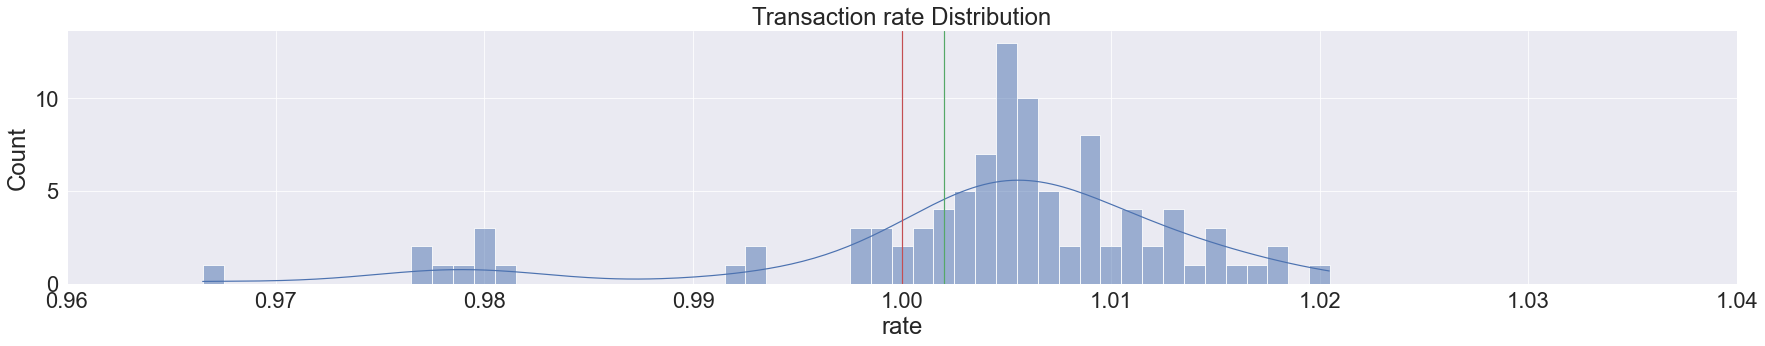

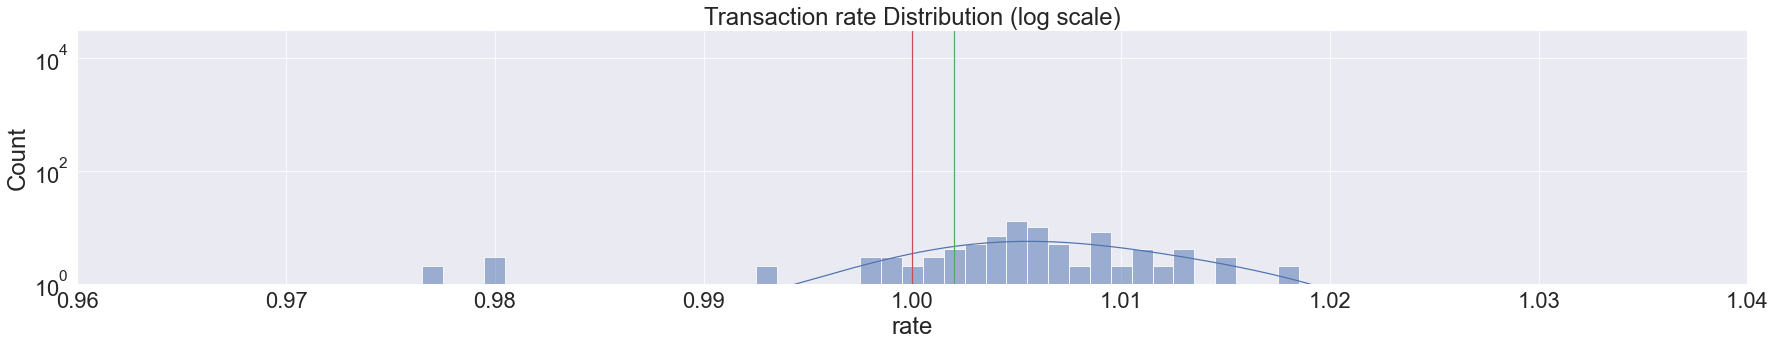

In [27]:
threshold = .68
y_train_pred = (clf.predict_proba(X_train_xgb)[:,1] > threshold).astype(bool)
y_val_pred = (clf.predict_proba(X_val_xgb)[:,1] > threshold).astype(bool)
y_test_pred = (clf.predict_proba(X_test_xgb)[:,1] > threshold).astype(bool)
print_scores()
draw_ml_distribution()

# stop_loss <= 89%
y_train_pred_xgb = y_train_pred.copy()
y_val_pred_xgb = y_val_pred.copy()
y_test_pred_xgb = y_test_pred.copy()

[18:07:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



			train		Bollinger
accuracy         	66.96%		49.38%
precision        	63.39%		49.38%
recall           	78.32%		100.00%
roc_auc          	67.10%		50.00%
confusion matrix 	[2024 1598]	[   0 3622]
                 	[ 766 2767]	[   0 3533]
money (comission=0)	3.40$			2.65$		
money (comission=.002)	0.30$			0.10$		
max loss		79.99%


			val		Bollinger
accuracy         	69.14%		50.73%
precision        	65.88%		50.73%
recall           	81.24%		100.00%
roc_auc          	68.96%		50.00%
confusion matrix 	[666 509]	[   0 1175]
                 	[227 983]	[   0 1210]
money (comission=0)	1.23$			1.32$		
money (comi

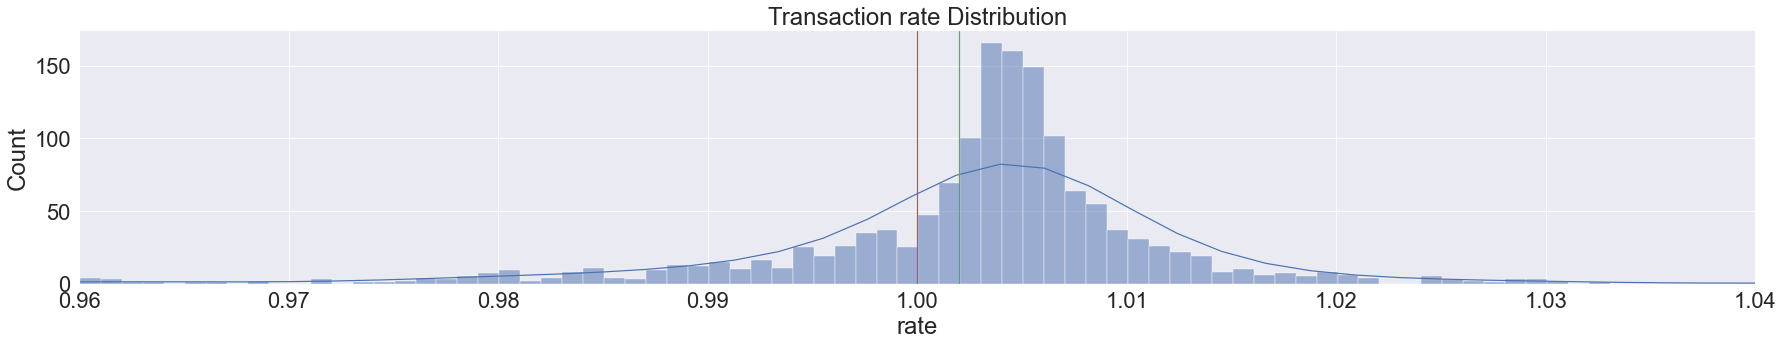

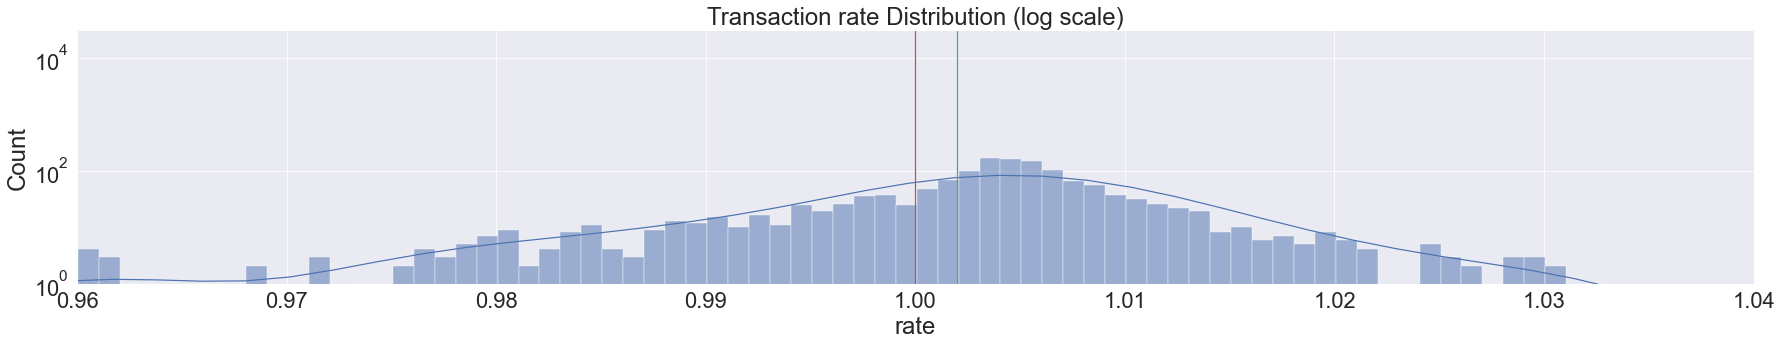

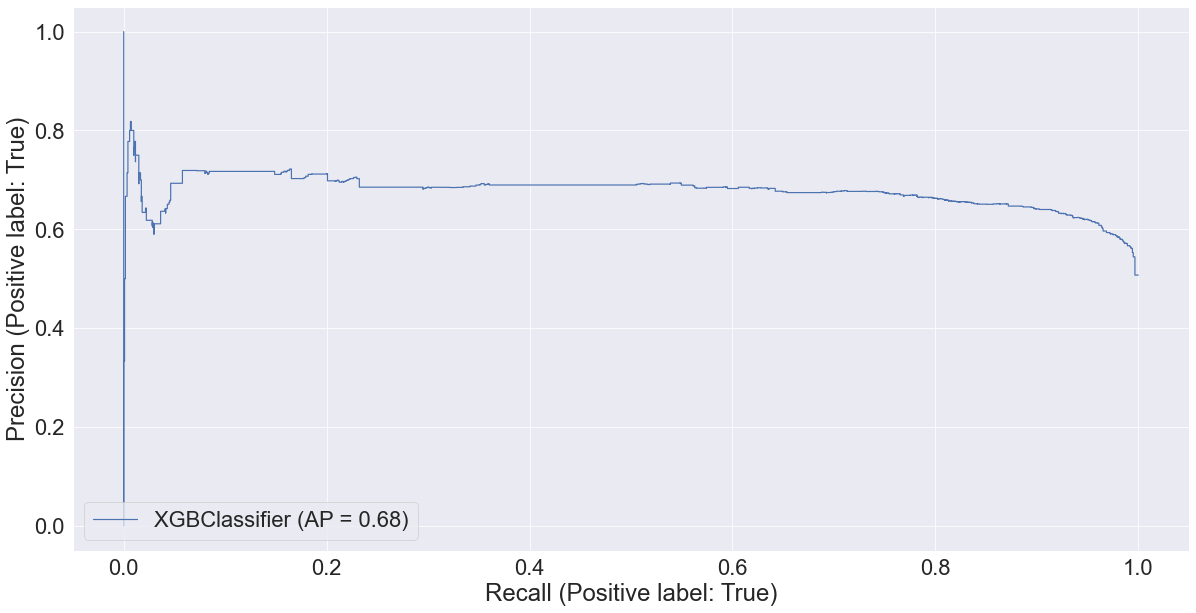

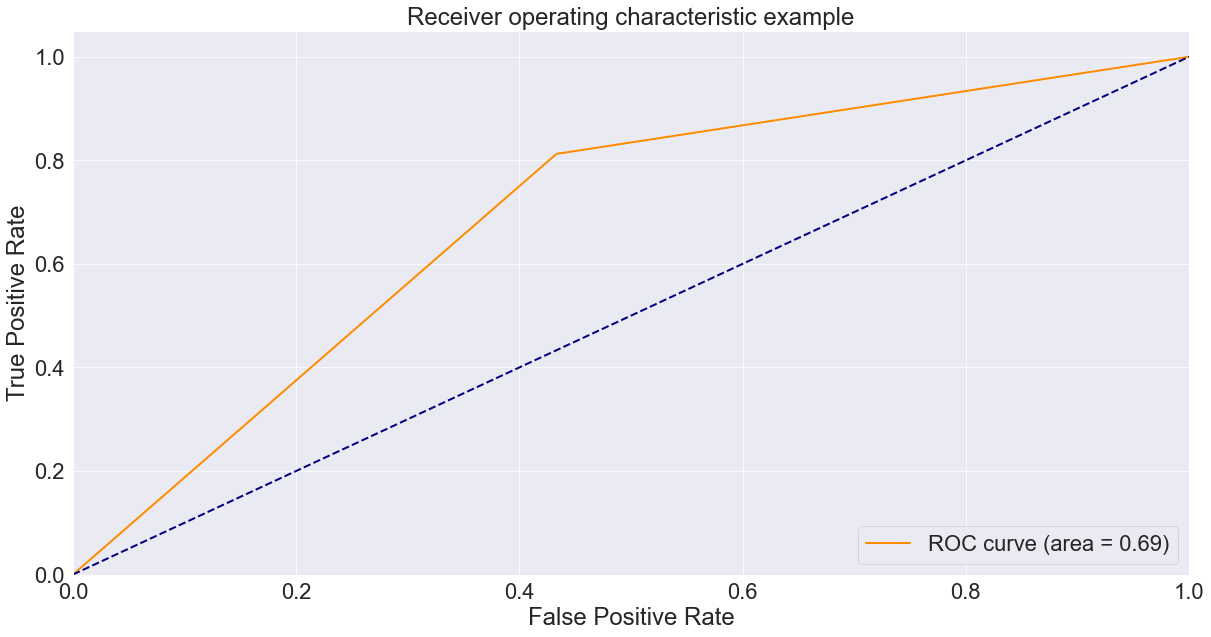

<Figure size 1440x720 with 0 Axes>

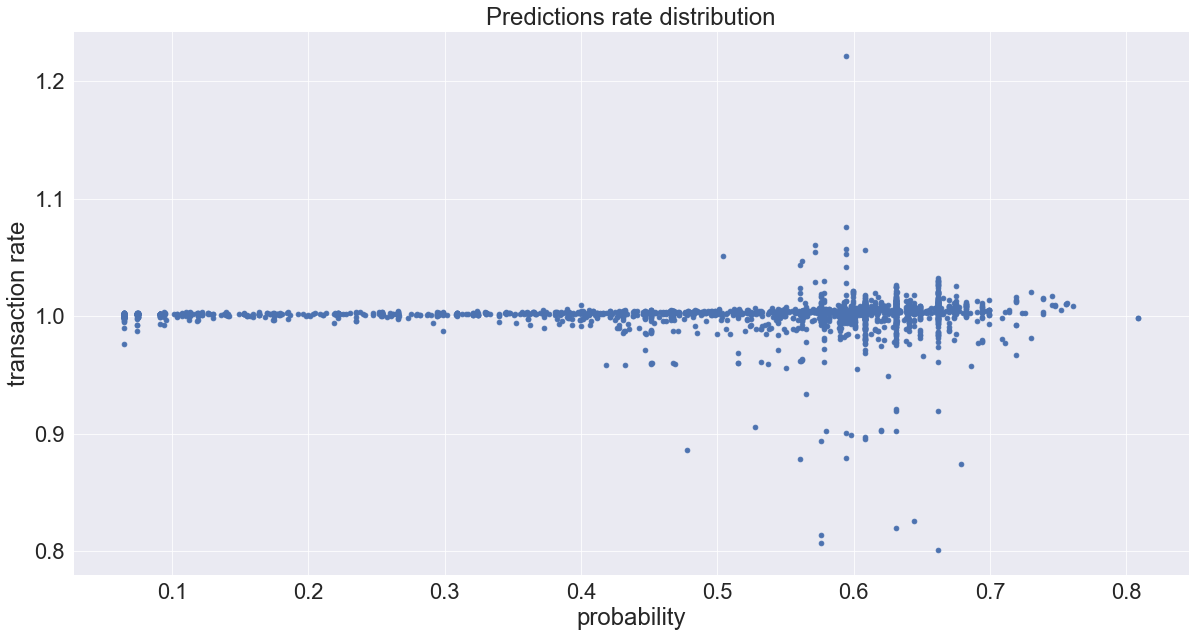

<Figure size 1440x720 with 0 Axes>

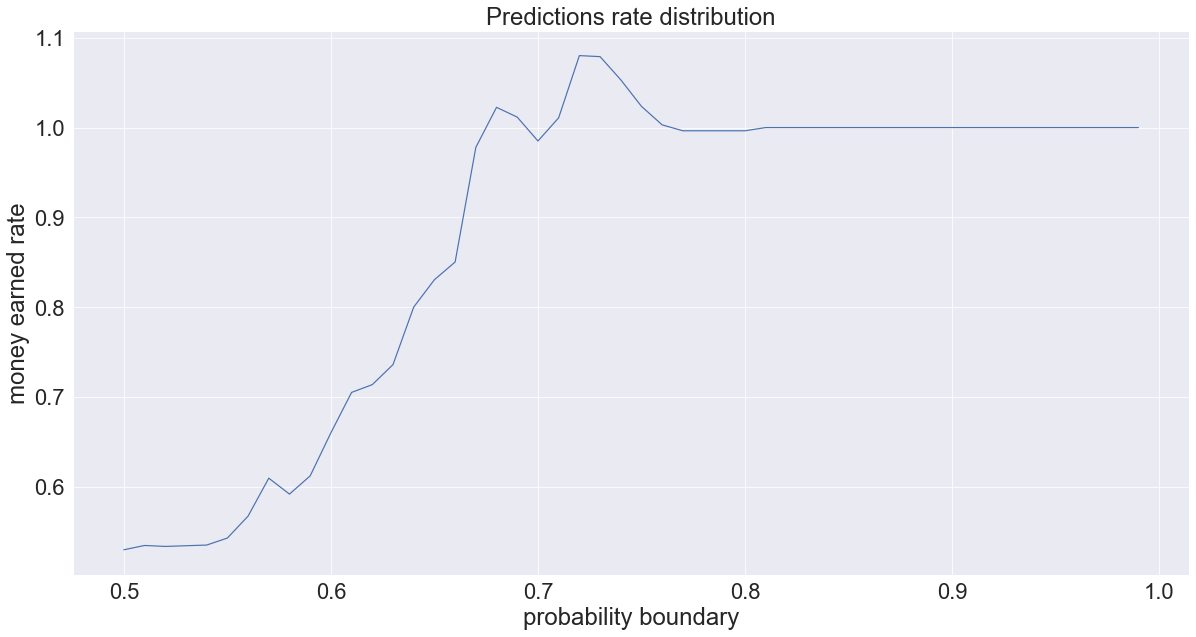

<Figure size 1440x720 with 0 Axes>

In [34]:
# NIE WYPAŁ
clf = XGBClassifier(class_weight='balanced', max_depth=4, gamma=15,reg_lambda=.1, use_label_encoder=False, eval_metric='logloss')
clf.fit(X_train_xgb_svm, y_train)

y_train_pred = (clf.predict_proba(X_train_xgb_svm)[:,1] >= 0.5).astype(bool)
y_val_pred = (clf.predict_proba(X_val_xgb_svm)[:,1] >= 0.5).astype(bool)
print_scores()
draw_ml_distribution()
plot_precision_recall_curve(clf, X_val_xgb_svm, y_val)
draw_roc_auc()
draw_rate_proba_scatter(clf.predict_proba(X_val_xgb_svm)[:,1], rate_in_out_val)
draw_money(clf.predict_proba(X_val_xgb_svm)[:,1])


			train		Bollinger
accuracy         	51.56%		49.38%
precision        	97.18%		49.38%
recall           	1.95%		100.00%
roc_auc          	50.95%		50.00%
confusion matrix 	[3620    2]	[   0 3622]
                 	[3464   69]	[   0 3533]
money (comission=0)	1.50$			2.65$		
money (comission=.002)	1.36$			0.10$		
max loss		91.15%


			val		Bollinger
accuracy         	49.64%		50.73%
precision        	73.68%		50.73%
recall           	1.16%		100.00%
roc_auc          	50.37%		50.00%
confusion matrix 	[1170    5]	[   0 1175]
                 	[1196   14]	[   0 1210]
money (comission=0)	1.12$			1.32$		
money (comission=.002)	1.08$			0.40$		
max loss		93.15%


			test		Bollinger
accuracy         	49.08%		51.13%
precision        	66.67%		51.13%
recall           	0.82%		100.00%
roc_auc          	50.20%		50.00%
confusion matrix 	[1161    5]	[   0 1166]
                 	[1210   10]	[   0 1220]
money (comission=0)	1.05$			2.00$		
money (comission=.002)	1.02$			0.63$		
max loss		93.32%

We made 19 tr

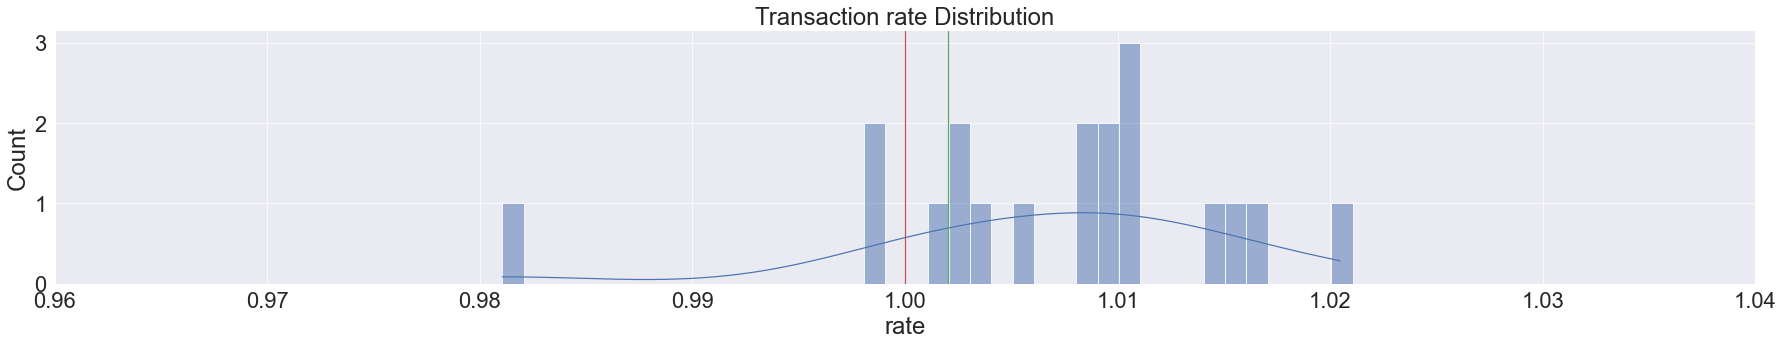

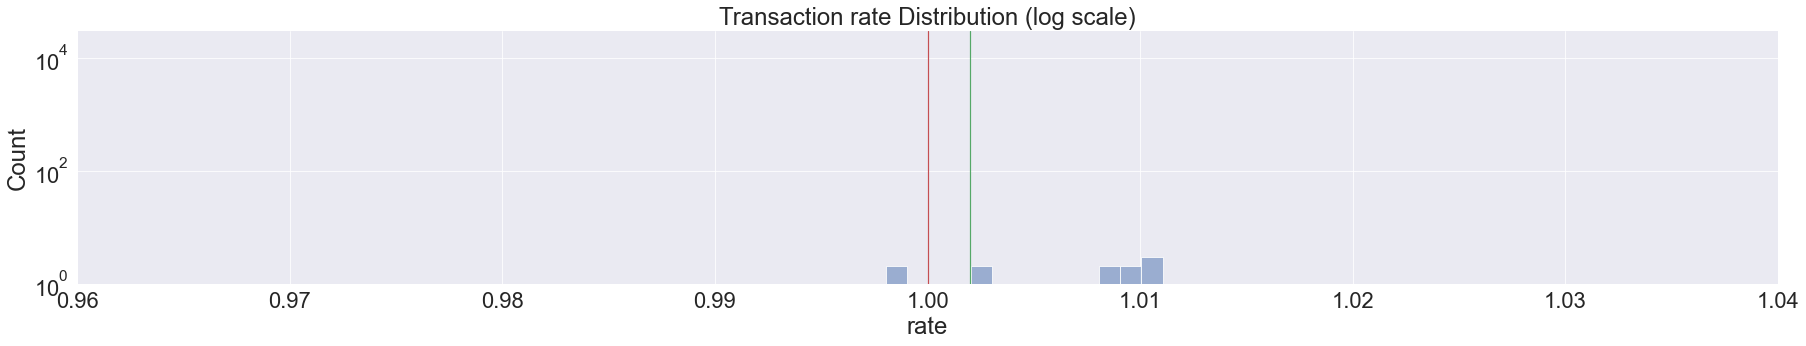

In [35]:
threshold = .72
y_train_pred = (clf.predict_proba(X_train_xgb_svm)[:,1] > threshold).astype(bool)
y_val_pred = (clf.predict_proba(X_val_xgb_svm)[:,1] > threshold).astype(bool)
y_test_pred = (clf.predict_proba(X_test_xgb_svm)[:,1] > threshold).astype(bool)
print_scores()
draw_ml_distribution()

y_train_pred_xgb_svm = y_train_pred.copy()
y_val_pred_xgb_svm = y_val_pred.copy()
y_test_pred_xgb_svm = y_test_pred.copy()

# stop_loss <= 89%

## **SVM**

In [297]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

parameters = {'C':[.1,.5,1,5,10], 'kernel':['rbf', 'poly', 'sigmoid'], 'degree':[2,3]}
clf = GridSearchCV(SVC(probability=True), parameters, verbose=10)
clf.fit(X_train, y_train)

GridSearchCV(estimator=SVC(probability=True),
             param_grid={'C': [0.1, 0.5, 1, 5, 10], 'degree': [2, 3],
                         'kernel': ['rbf', 'poly', 'sigmoid']})

In [303]:
clf.cv_results_

{'mean_fit_time': array([43.91965289, 42.12363272, 45.19850039, 47.2984097 , 41.5005322 ,
        46.56617312, 49.13103895, 42.95640225, 43.47587252, 45.02424765,
        41.23675351, 42.34264812, 44.44590402, 42.08938098, 43.17065115,
        45.2134438 , 41.17526326, 43.75587578, 46.30213857, 41.89598894,
        43.60870876, 45.02125301, 40.82313604, 48.68134775, 50.40042467,
        42.84626822, 44.45571284, 48.1075139 , 40.02271886, 48.33125296]),
 'std_fit_time': array([1.86582003, 0.79569401, 1.9102053 , 2.3432556 , 0.90791853,
        1.47987448, 0.53592474, 0.88211138, 0.33580399, 0.40271413,
        0.44205359, 0.25275213, 1.01873692, 0.23224037, 0.75643305,
        0.29577826, 1.08333802, 0.48511531, 1.81846325, 1.35413803,
        0.58400216, 0.84602599, 2.33765748, 3.67423887, 2.89896214,
        1.53453928, 1.57376086, 6.70622231, 0.77313627, 0.71111369]),
 'mean_score_time': array([2.34282513, 1.33429327, 1.63928437, 2.52355514, 1.23196764,
        1.61287313, 2.61271391

In [304]:
clf.best_params_

{'C': 10, 'degree': 3, 'kernel': 'poly'}


			train		Bollinger
accuracy         	57.01%		49.38%
precision        	65.43%		49.38%
recall           	27.43%		100.00%
roc_auc          	56.65%		50.00%
confusion matrix 	[3110  512]	[   0 3622]
                 	[2564  969]	[   0 3533]
money (comission=0)	2.32$			2.65$		
money (comission=.002)	0.88$			0.10$		
max loss		79.99%


			val		Bollinger
accuracy         	60.42%		50.73%
precision        	69.56%		50.73%
recall           	39.09%		100.00%
roc_auc          	60.74%		50.00%
confusion matrix 	[968 207]	[   0 1175]
                 	[737 473]	[   0 1210]
money (comission=0)	1.12$			1.32$		
money (comission=.002)	0.72$			0.40$		
max loss		69.77%


			test		Bollinger
accuracy         	56.45%		51.13%
precision        	66.61%		51.13%
recall           	29.75%		100.00%
roc_auc          	57.07%		50.00%
confusion matrix 	[984 182]	[   0 1166]
                 	[857 363]	[   0 1220]
money (comission=0)	1.52$			2.00$		
money (comission=.002)	1.08$			0.63$		
max loss		93.07%

We made 680 transa

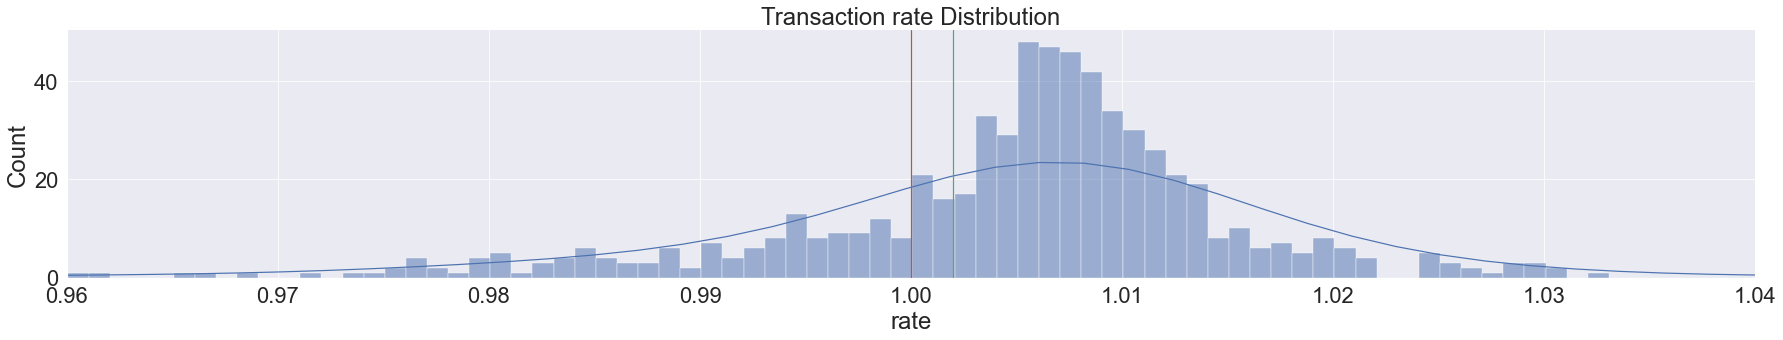

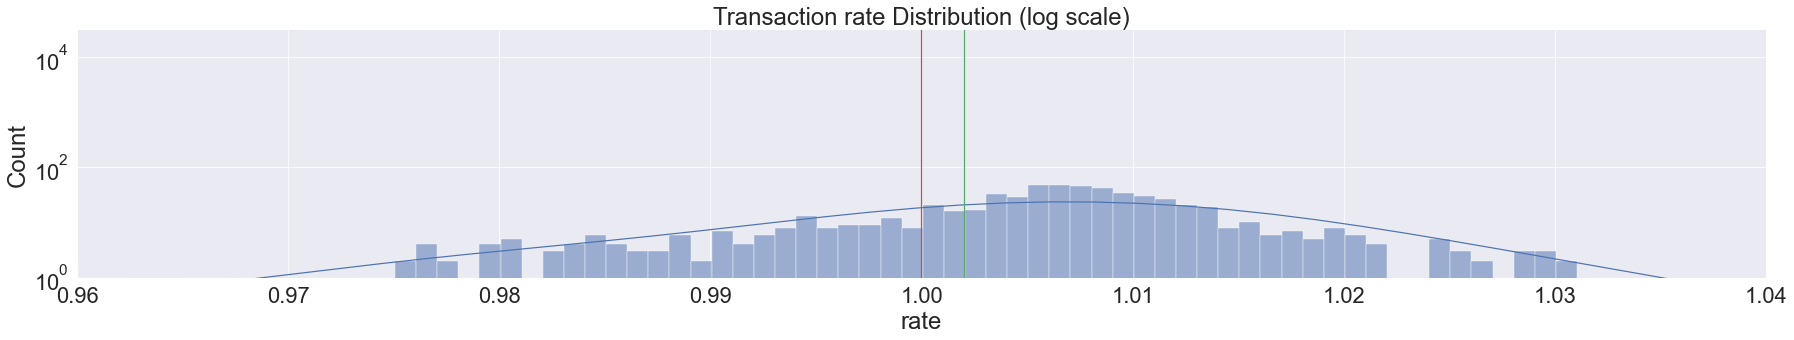

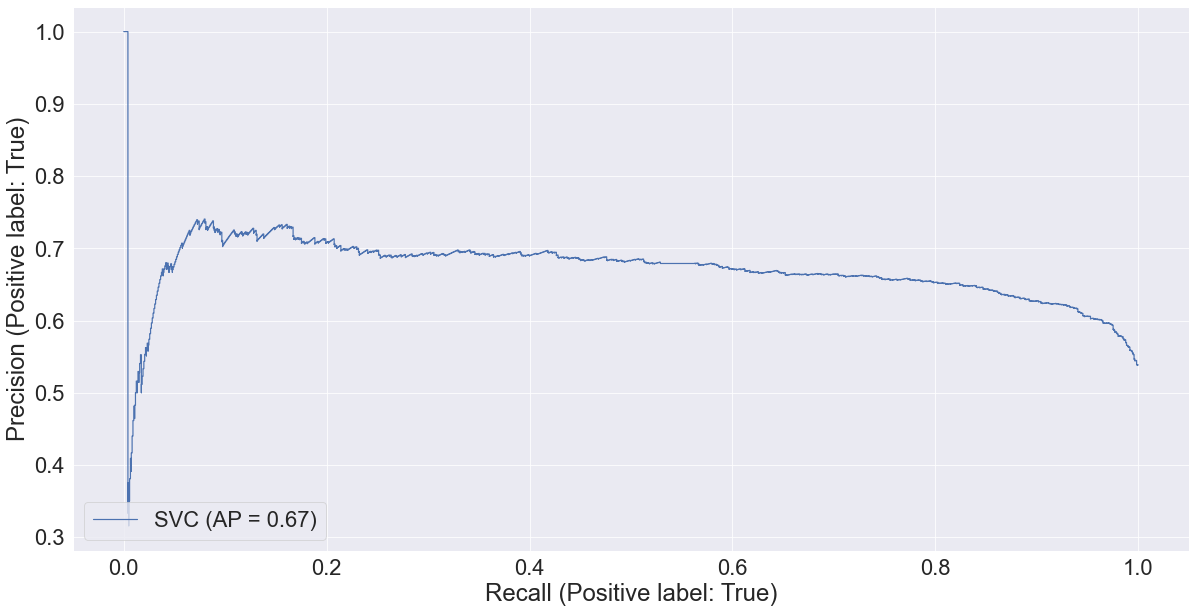

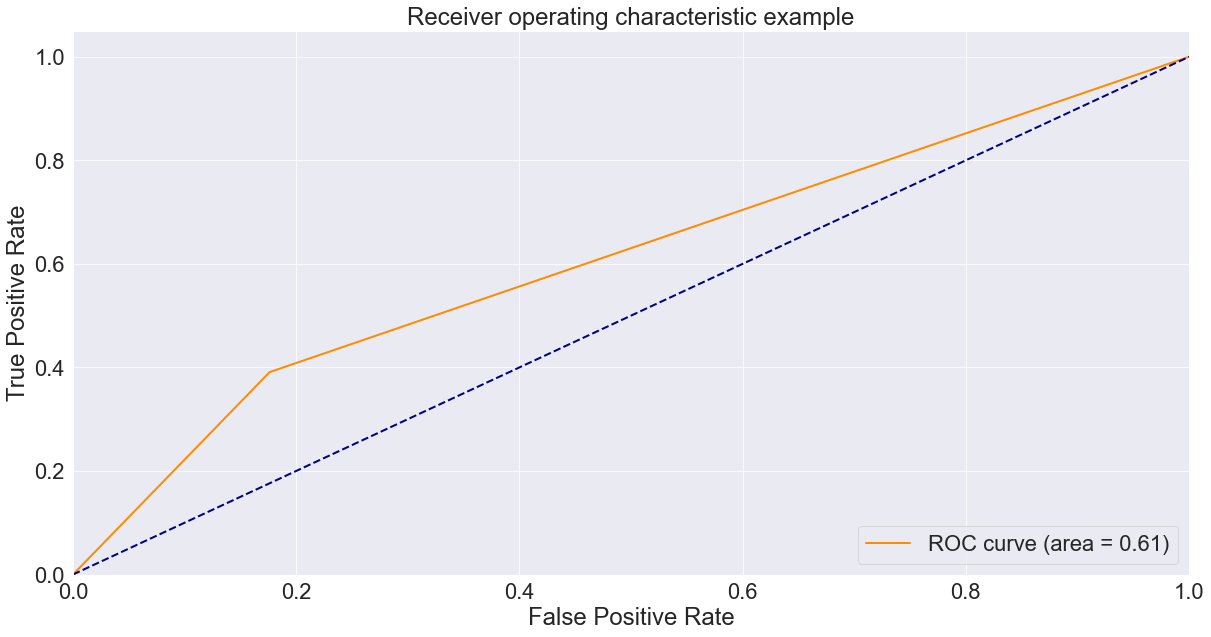

<Figure size 1440x720 with 0 Axes>

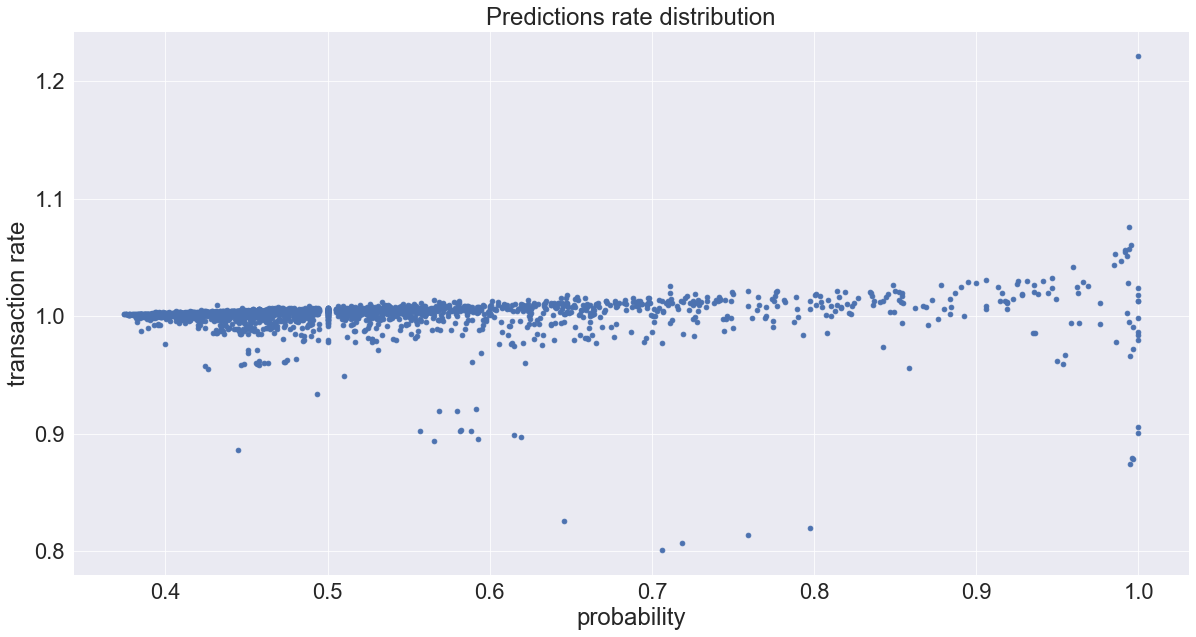

<Figure size 1440x720 with 0 Axes>

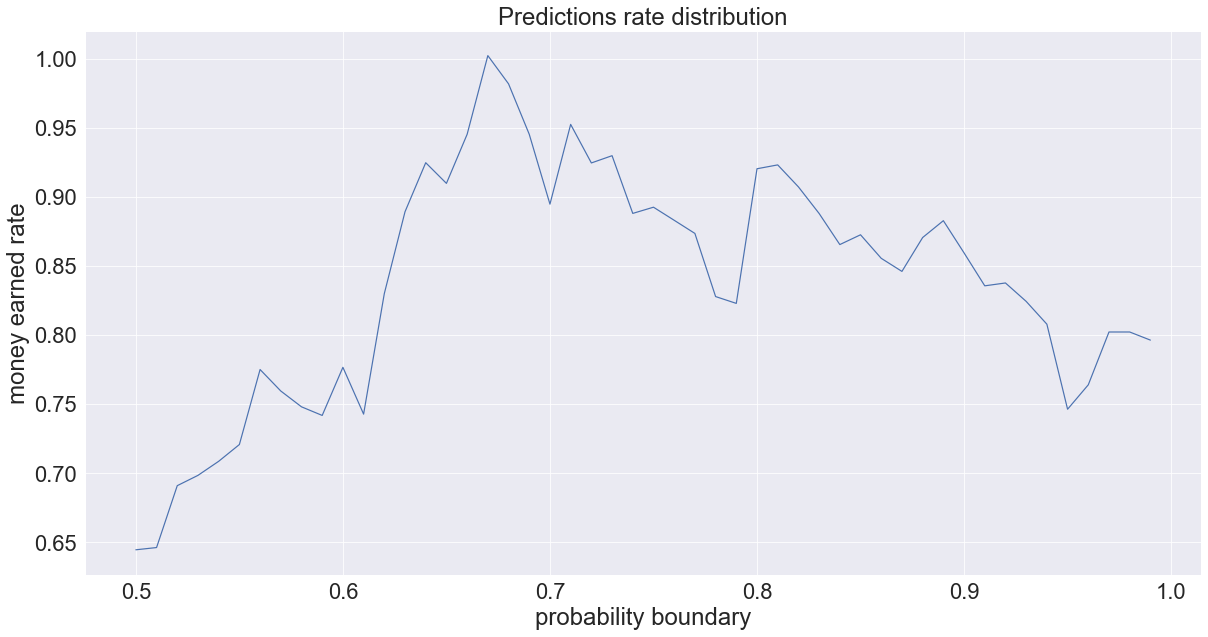

<Figure size 1440x720 with 0 Axes>

In [216]:
from sklearn.svm import SVC
clf = SVC(probability=True, **{'C': 10, 'degree': 3, 'kernel': 'poly'})
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_val_pred = clf.predict(X_val)
y_test_pred = clf.predict(X_test)

print_scores()
draw_ml_distribution()
plot_precision_recall_curve(clf, X_val, y_val)
draw_roc_auc()
draw_rate_proba_scatter(clf.predict_proba(X_val)[:,1], rate_in_out_val)
draw_money(clf.predict_proba(X_val)[:,1])

In [30]:
X_train_xgb_svm[353] = clf.predict_proba(X_train)[:,1]
X_test_xgb_svm[353] = clf.predict_proba(X_test)[:,1]
X_val_xgb_svm[353] = clf.predict_proba(X_val)[:,1]


			train		Bollinger
accuracy         	53.18%		49.38%
precision        	68.48%		49.38%
recall           	9.60%		100.00%
roc_auc          	52.64%		50.00%
confusion matrix 	[3466  156]	[   0 3622]
                 	[3194  339]	[   0 3533]
money (comission=0)	1.85$			2.65$		
money (comission=.002)	1.24$			0.10$		
max loss		80.86%


			val		Bollinger
accuracy         	54.47%		50.73%
precision        	73.31%		50.73%
recall           	16.12%		100.00%
roc_auc          	55.04%		50.00%
confusion matrix 	[1104   71]	[   0 1175]
                 	[1015  195]	[   0 1210]
money (comission=0)	1.22$			1.32$		
money (comission=.002)	1.00$			0.40$		
max loss		69.77%


			test		Bollinger
accuracy         	52.31%		51.13%
precision        	77.70%		51.13%
recall           	9.43%		100.00%
roc_auc          	53.30%		50.00%
confusion matrix 	[1133   33]	[   0 1166]
                 	[1105  115]	[   0 1220]
money (comission=0)	1.49$			2.00$		
money (comission=.002)	1.34$			0.63$		
max loss		93.07%

We made 266 

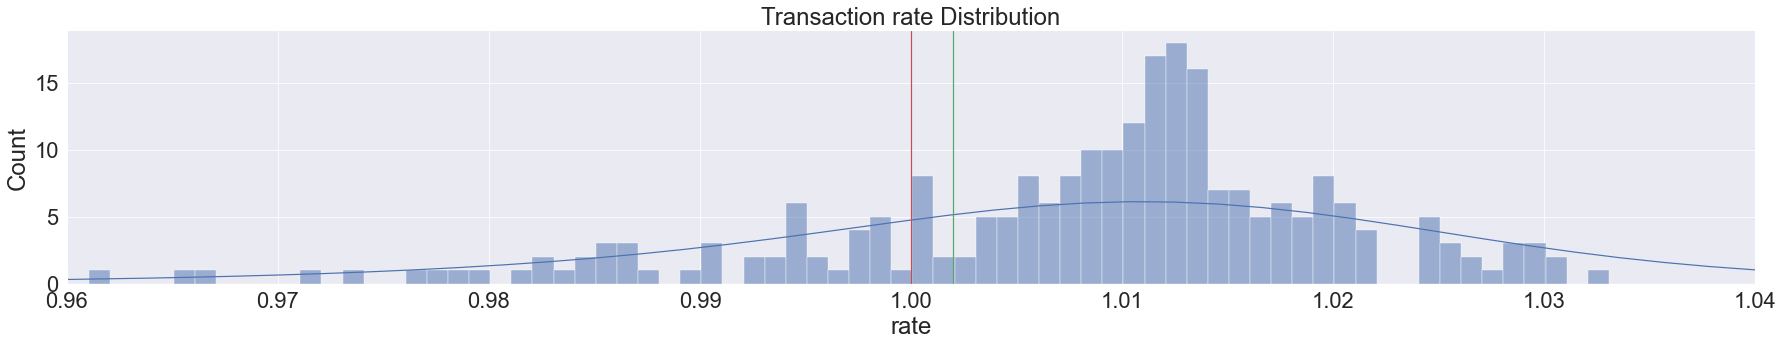

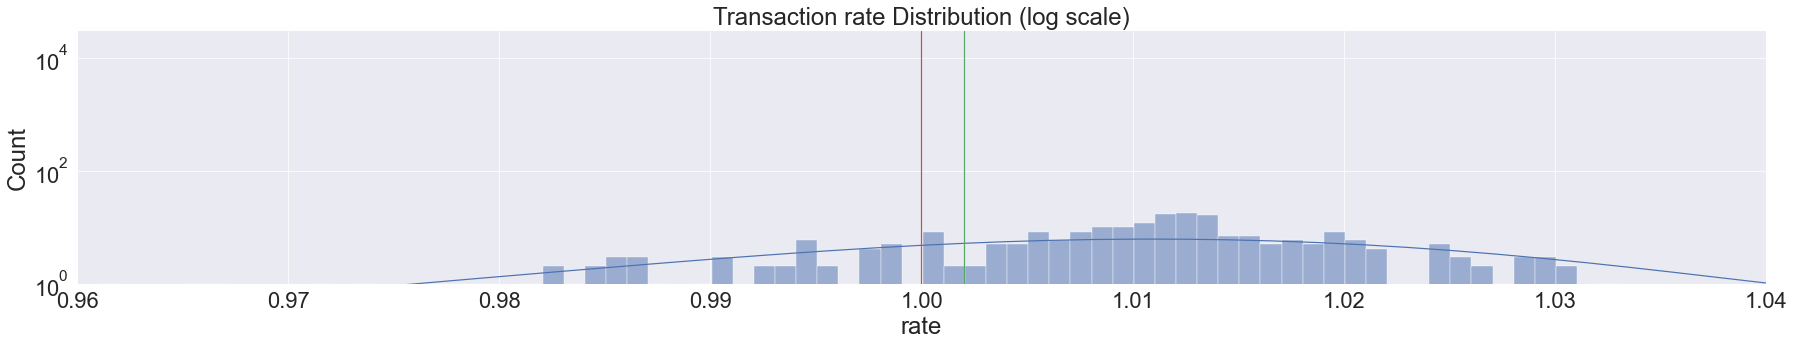

In [217]:
threshold = .67
y_train_pred = (clf.predict_proba(X_train)[:,1] > threshold).astype(bool)
y_val_pred = (clf.predict_proba(X_val)[:,1] > threshold).astype(bool)
y_test_pred = (clf.predict_proba(X_test)[:,1] > threshold).astype(bool)
print_scores()
draw_ml_distribution()

y_train_pred_svm = y_train_pred.copy()
y_val_pred_svm = y_val_pred.copy()
y_test_pred_svm = y_test_pred.copy()
# thresh = .67, stoploss=.93

We've ended up with 1.23 return


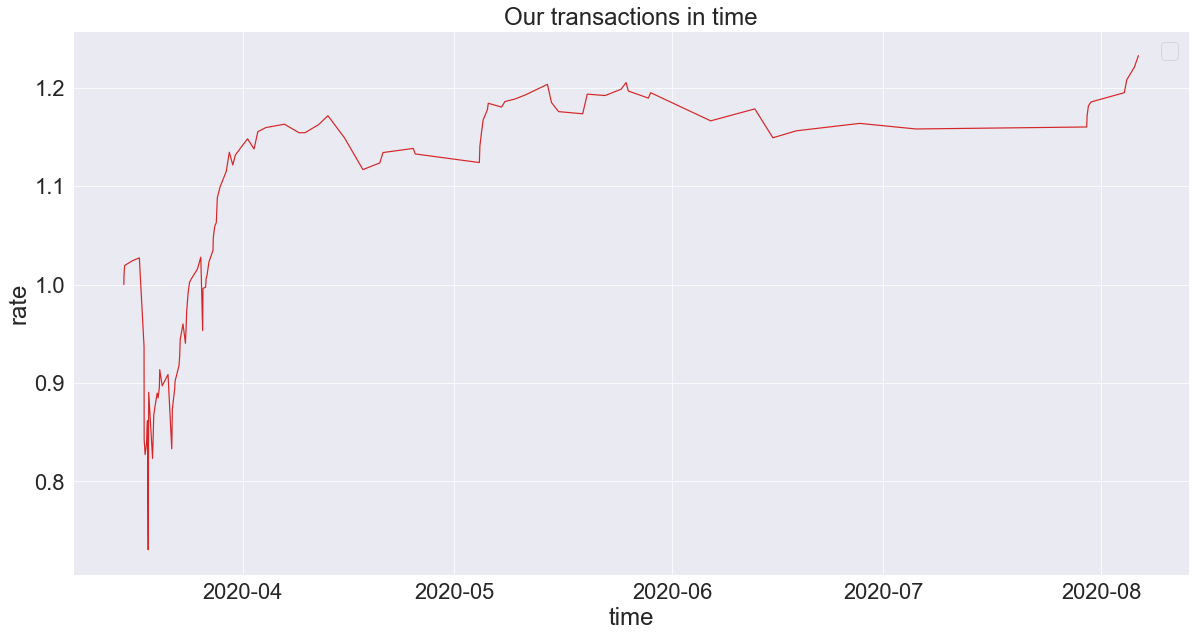

In [236]:
draw_money_history(
    money_leverage_counter(y_val_pred, stop_loss(y_val_pred, rate_in_out_val, stop_rate=.93), commission=.998, history=True))

In [30]:
result = thresh_loss(clf, 'val', step_t=.01, step_l=.01, begin_t=60, end_t=100, begin_l=70, end_l=100)
draw_thresh_loss_money(*result)

Time of execution : 118.06 seconds


In [326]:
result = thresh_loss(clf, 'test', step_t=.01, step_l=.01, begin_t=60, end_t=100, begin_l=70, end_l=100)
draw_thresh_loss_money(*result)

Time of execution : 53.96 seconds


In [ ]:
result = thresh_loss(clf, 'train', step_t=.01, step_l=.01, begin_t=60, end_t=100, begin_l=70, end_l=100)
draw_thresh_loss_money(*result)

In [22]:
from sklearn.svm import SVC
from importlib import reload
import skopt
reload(skopt)
# from skopt import BayesSearchCV
# from skopt.space import Real, Categorical, Integer
# from sklearn.model_selection import GridSearchCV
# def bayes_search_CV_init(self, estimator, search_spaces, optimizer_kwargs=None,
#                          n_iter=50, scoring=None, fit_params=None, n_jobs=1,
#                          n_points=1, iid=True, refit=True, cv=None, verbose=0,
#                          pre_dispatch='2*n_jobs', random_state=None,
#                          error_score='raise', return_train_score=False):

#         self.search_spaces = search_spaces
#         self.n_iter = n_iter
#         self.n_points = n_points
#         self.random_state = random_state
#         self.optimizer_kwargs = optimizer_kwargs
#         self._check_search_space(self.search_spaces)
#         self.fit_params = fit_params

#         super(BayesSearchCV, self).__init__(
#              estimator=estimator, scoring=scoring,
#              n_jobs=n_jobs, refit=refit, cv=cv, verbose=verbose,
#              pre_dispatch=pre_dispatch, error_score=error_score,
#              return_train_score=return_train_score)
        
# BayesSearchCV.__init__ = bayes_search_CV_init

<module 'skopt' from 'C:\\Users\\atom\\AppData\\Roaming\\Python\\Python39\\site-packages\\skopt\\__init__.py'>

In [24]:
# parameters = {'C':[.1,.5,1,5,10,20,50], 'degree':[1,2,3,4,5]}
clf = skopt.BayesSearchCV(
    SVC(probability=True),
#     SVC(),
    {
        'C': skopt.space.Real(1e-6, 1e+6, prior='log-uniform'),
#         'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
        'degree': skopt.space.Integer(1,8),
#         'kernel': Categorical(['linear', 'poly', 'rbf', 'sigmoid']),
        'kernel': skopt.space.Categorical(['poly']),
    },
    n_iter=32,
    random_state=17,
    n_jobs=4,
    verbose=10
#     iid='deprecated'
)
clf.fit(X_train, y_train)

TypeError: __init__() got an unexpected keyword argument 'iid'

In [27]:
# from skopt import BayesSearchCV
reload(skopt)
from sklearn.datasets import load_iris
from sklearn.svm import SVC

X, y = load_iris(return_X_y=True)

searchcv = skopt.BayesSearchCV(
    SVC(gamma='scale'),
    search_spaces={'C': (0.01, 100.0, 'log-uniform')},
    n_iter=10,
    cv=3
)

# callback handler
def on_step(optim_result):
    score = searchcv.best_score_
    print("best score: %s" % score)
    if score >= 0.98:
        print('Interrupting!')
        return True


searchcv.fit(X, y, callback=on_step)

TypeError: __init__() got an unexpected keyword argument 'iid'

In [17]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

parameters = {'C':[.1], 'kernel':['poly'], 'degree':[2]}
clf = RandomizedSearchCV(SVC(probability=True), parameters, verbose=10, n_jobs=2)
clf.fit(X_train, y_train)

C:\Users\atom\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


RandomizedSearchCV(estimator=SVC(probability=True), n_jobs=2,
                   param_distributions={'C': [0.1], 'degree': [2],
                                        'kernel': ['poly']},
                   verbose=10)

We've ended up with 1.15 return


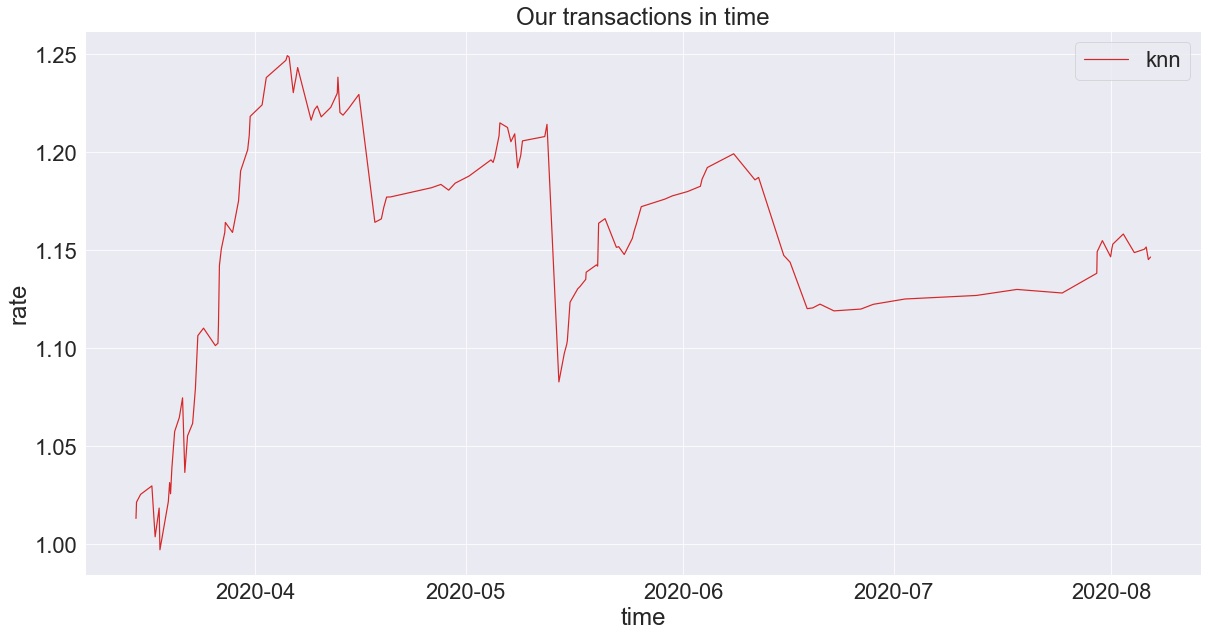

In [41]:
hist = money_leverage_counter(y_val_pred_knn, rate_in_out_val, commission=.998, leverage=1, history=True)
draw_money_history(hist, legende=["knn"])
# print(hist[0])

We've ended up with 1.15 return
We've ended up with 1.12 return
We've ended up with 1.08 return
We've ended up with 1.23 return


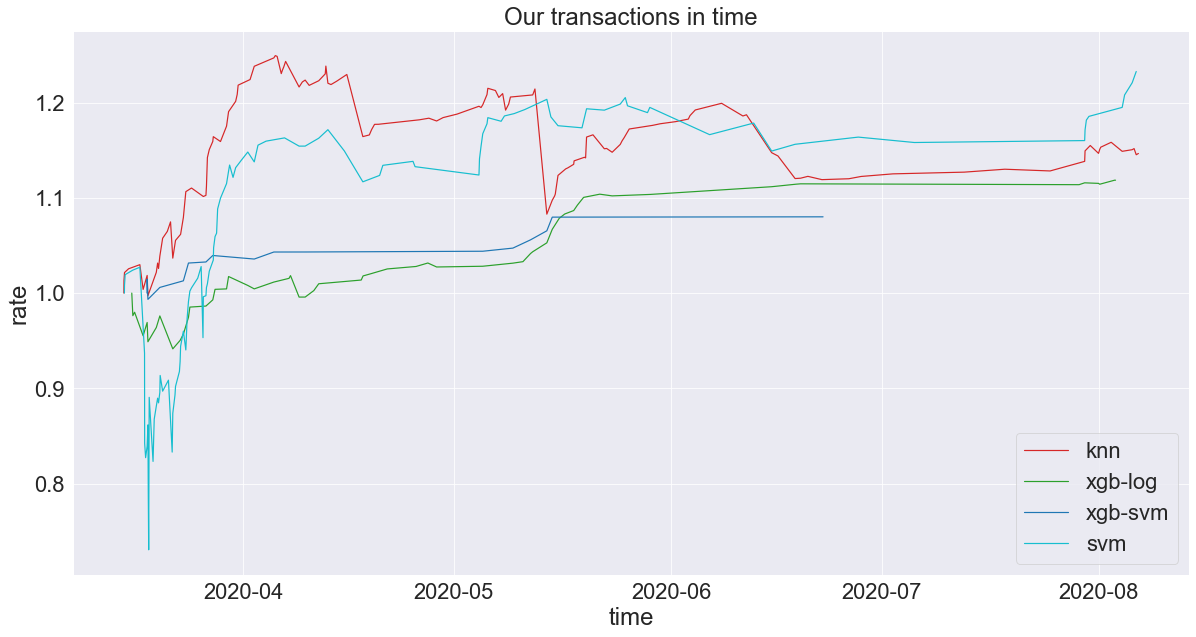

In [158]:
hist = money_leverage_counter(y_val_pred_xgb, rate_in_out_val, commission=.998, leverage=1, history=True)
draw_money_history(money_leverage_counter(y_val_pred_knn, rate_in_out_val, commission=.998, leverage=1, history=True),
                   money_leverage_counter(y_val_pred_xgb, rate_in_out_val, commission=.998, leverage=1, history=True),
                   money_leverage_counter(y_val_pred_xgb_svm, rate_in_out_val, commission=.998, leverage=1, history=True),
                   money_leverage_counter(y_val_pred_svm, stop_loss(y_val_pred_svm, rate_in_out_val, stop_rate=.93), commission=.998, leverage=1, history=True),
                  legende=['knn', 'xgb-log', 'xgb-svm', 'svm'])
# print(hist)

In [ ]:
# import operator
# def clf_combo(*preds, op=operator.or_):
# #     return pred2 | pred2
#     from functools import reduce
#     return reduce(op, preds)
#     return reduce(lambda x,y:x|y, preds)
def clf_or(pred1, pred2):
    return pred1 | pred2
def clf_and(pred1, pred2):
    return pred1 & pred2
import operator
from functools import reduce
def clf_combo(clfs=[], thresholds=[], train_data=[], test_data=[], op=operator.or_):
    preds = []
    for clf, threshold, train, test in zip(clfs, thresholds, train_data, test_data):
        X_train = eval(f'X_{train}')
        y_train = eval(f'X_{train}')
        X_test = eval(f'X_{test}')
        clf.fit(X_train, y_train)
        y_pred = (clf.predict_proba(X_test)[:,1] > threshold).astype(bool)
        preds.append(y_pred)
    return reduce(op, preds)

clfs = [
    XGBClassifier(max_depth=4, gamma=15,reg_lambda=.1, use_label_encoder=False, eval_metric='logloss'),
    KNeighborsClassifier(n_neighbors=10)
]
thresholds = [
    .68,
    .89
]
train_data = [
    'train_xgb',
    'train',
]
test_data = [
    'val_xgb',
    'val'
]


In [355]:
def clf_combined(y_pred, rate_in_out, commission=1, leverage=1, uncle=1, history=True, clfs=[]):
    df = pd.concat([rate_in_out, y_pred], axis=1)
#     return df
#     return df
    stop_dict = {'knn':.8, 'xgb-log':.8, 'xgb-svm':.8, 'svm':.93}
    moeny = 1. * uncle
    prev_out = -1
    hist = pd.DataFrame(columns=df.columns)
    hist = hist.append({'rate':moeny, 'index_out':df.loc[df.index[0], 'index_in']}, ignore_index=True)
    for i in df.index:
        row = df.loc[i].copy()
        if row['index_in'] <= prev_out:
            continue
        if not row[clfs].any():
            continue

        new_rate = row['rate']
        stop_rate = min(stop_dict[clf] for clf in row[clfs][row[clfs]].index)
        between_in_out = stock.stock_df.loc[row['index_in']:row['index_out'], 'open']
        in_value = between_in_out.iloc[0]
        stop_value = in_value * stop_rate
        bigger_losses = between_in_out[between_in_out < stop_value]
        if bigger_losses.any():
            row['index_out'] = bigger_losses.index[0]
            new_rate = bigger_losses.iloc[0] / in_value
        
#         new_rate = row['rate']
#         for value in between_in_out:
#             if value < stop_value:
#                 new_rate = value / in_value
#                 return new_rate, in_value, stop_value, value, between_in_out, row
#                 break
# #         else:
            
            
        moeny = moeny * (leverage*new_rate*commission - leverage + 1)
        prev_out = row['index_out']
        
        if history:
            row['rate'] = moeny  
            row['id'] = i
            hist = hist.append(row, ignore_index=True)
#             df.loc[i,'rate'] = row['rate']
#             df.loc[i,'index_out'] = row['index_out']
            
    if history:
        return moeny - uncle + 1, hist
    return moeny - uncle + 1


def clf_combined_(data='', **kwargs):
    return clf_combined(pd.DataFrame(np.array([eval(f'y_{data}_pred_knn'), 
                                               eval(f'y_{data}_pred_xgb'), 
                                               eval(f'y_{data}_pred_svm'),
                                               eval(f'y_{data}_pred_xgb_svm')]).T, 
                        columns=['knn', 'xgb-log', 'svm', 'xgb-svm'], 
                        index=eval(f'rate_in_out_{data}').index), 
                        eval(f'rate_in_out_{data}'),
                        **kwargs)

# h = clf_combined(pd.DataFrame(np.array([y_val_pred_knn, y_val_pred_xgb, y_val_pred_svm]).T, 
#                           columns=['knn', 'xgb-log', 'svm'], 
#                           index=rate_in_out_val.index), 
#              rate_in_out_val,
#             commission=.998)
# draw_money_history(h)

We've ended up with 1.20 return
We've ended up with 0.40 return


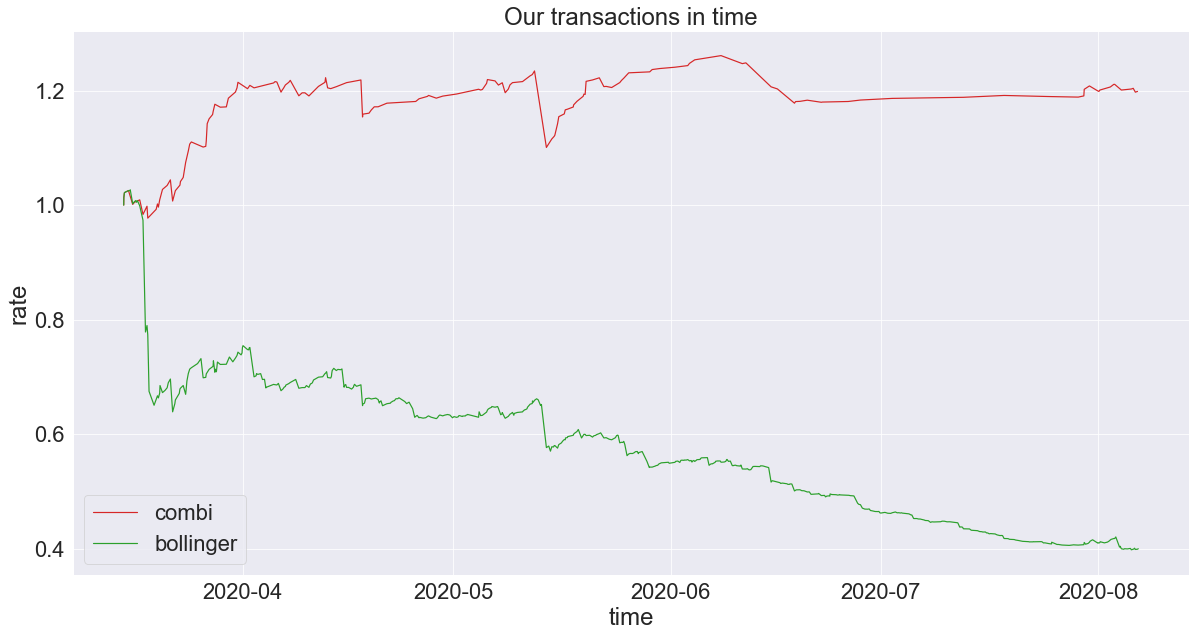

In [328]:
draw_money_history(clf_combined_('val', commission=.998, uncle=1, leverage=1, clfs=['knn', 'xgb-log', 'xgb-svm']),
                   
#     money_leverage_counter(y_val_pred, stop_loss(y_val_pred, rate_in_out_val, stop_rate=.93), commission=.998, history=True),
                money_leverage_counter(y_val_original, rate_in_out_val, commission=.998, leverage=1, history=True),
                  legende=['combi', 'bollinger'])

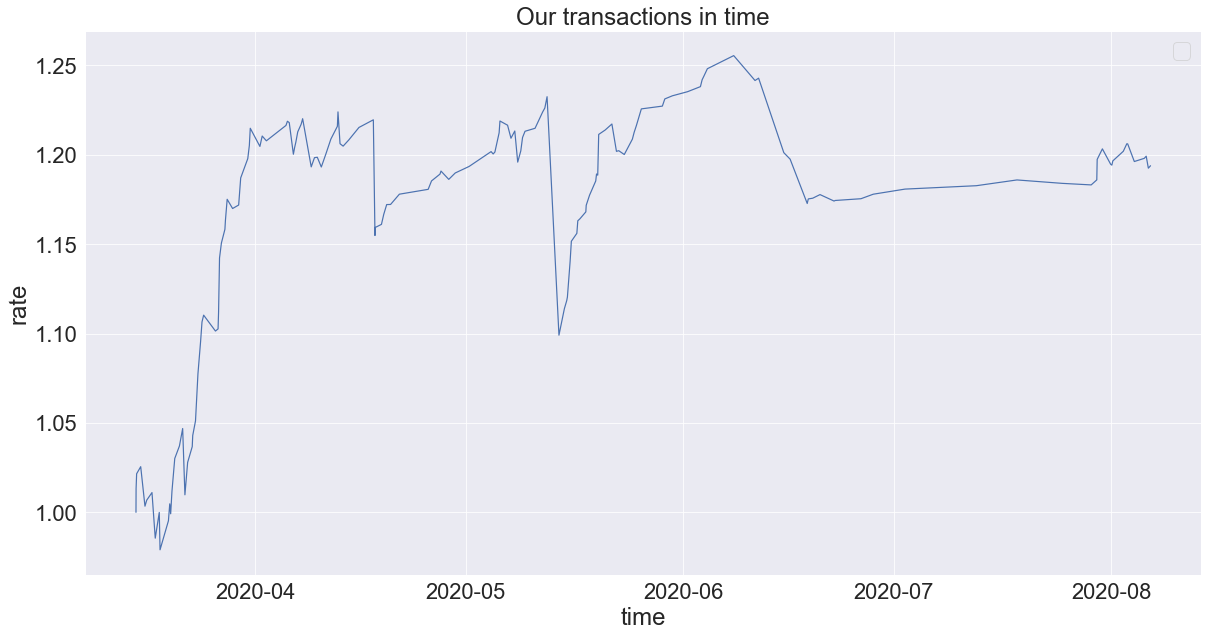

In [453]:
def portfolio(methods={}, data='val'):
    indeksy = set()
    for key in methods:
        methods[key]['result_money'], methods[key]['result_history']  = clf_combined_(data, commission=.998, clfs=list(key))
        indeksy.update(list(methods[key]['result_history']['index_out']))
        
    indeksy = sorted(indeksy)
    for key in methods:
        methods[key]['result_history'].set_index('index_out', inplace=True)
        methods[key]['df'] = pd.DataFrame(index=indeksy, columns=['rate']).fillna(methods[key]['result_history']).fillna(method='ffill')
    
    DF = pd.DataFrame(index=indeksy, columns=['rate']).fillna(0)
    weight_sum = 0
    for key in methods:
        DF += methods[key]['weight'] * methods[key]['df']
        weight_sum += methods[key]['weight']
    DF /= weight_sum
    DF = DF.reset_index().rename(columns={'index' : 'index_out'})
    draw_money_history((1, DF))
    

portfolio(methods={
    ('knn',) : {'weight' : 1},
    ('knn', 'xgb-log', 'xgb-svm') : {'weight' : 10}
})
    
    

In [ ]:
ml_data, X_trin, test = .75, 
test 6, 
po koleij 
liczymii fity
wykres
i dopierdalamy do kurwein


In [127]:
size = len(ml_data)
indexes = [0]+[int(size*.75) + i*int(size/24) for i in range(7)]
indexes[-1] = size+1
sets = {}
for i,j in zip(range(0,7), range(1,8)):
    all = ml_data.iloc[indexes[i]:indexes[j]]
    sets[f'X{i}'] = all.loc[:,1:350].copy()
    sets[f'y{i}'] = all.loc[:,0].copy()
    sets[f'X{i}_xgb_log'] = all.loc[:,1:350].copy()
    sets[f'X{i}_xgb_svm'] = all.loc[:,1:350].copy()
    sets[f'rate_in_out{i}'] = all.loc[:,351:353].copy()
clfs = {
    'knn' : {
        'clf' : KNeighborsClassifier(n_neighbors=10),
        'threshold' : .89
    },
    'log' : {
        'clf' : LogisticRegression(class_weight='balanced', penalty='l2'),
        'threshold' : None
    },
    'svm' : {
        'clf' : SVC(probability=True, **{'C': 10, 'degree': 3, 'kernel': 'poly'}),
        'threshold' : .67
    },
    'xgb_log' : {
        'clf' : XGBClassifier(max_depth=4, gamma=15,reg_lambda=.1, use_label_encoder=False, eval_metric='logloss'),
        'threshold' : .68
    },
    'xgb_svm' : {
        'clf' : XGBClassifier(class_weight='balanced', max_depth=4, gamma=15,reg_lambda=.1, use_label_encoder=False, eval_metric='logloss'),
        'threshold' : .72
    },
}


In [126]:
for i in range(1,7):
    X_train = pd.concat([sets[f'X{j}'] for j in range(i)])
    y_train = pd.concat([sets[f'X{j}'] for j in range(i)])
    X_test = sets[f'X{i}']
    y_test = sets[f'y_{i}']

0       False
1       False
2       False
3       False
4       False
        ...  
8939    False
8940     True
8941    False
8942    False
8943     True
Name: 0, Length: 8944, dtype: bool